##  Preliminary Analysis 

Alex Lu 
January 25th, 2019 

---

Analysis of artificial aneurysms introduced in the RCA and LAD for `z_scores = [6, 8, 10, 12, 14]`, with following params: 
* RCA: ASI = 2, positions = proximal, medial, distal
* RCA: ASI = 4, positions = proximal
* RCA: ASI = 6, positions = proximal
* LAD: ASI = 2, positions = proximal 
* LAD: ASI = 4, positions = proximal
* LAD: ASI = 6, positions = proximal 


Import external dependencies.

In [35]:
import numpy as np
import vtk
from vtk.util import numpy_support as nps
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os 
from IPython.display import HTML

from matplotlib import rc
plt.rcParams.update(plt.rcParamsDefault)
%config InlineBackend.figure_format = 'retina'

Import other requirements

In [2]:
from AneurysmGeneration.utils.batch import *  # for I/O

Configure display styles 

In [36]:
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              #'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [37]:
latexify()

In [3]:
# sns.set(rc={"figure.figsize":(8,6)})
# sns.set_style('white', {'axes.spines.right':False})
# sns.set_style('ticks')
# sns.set_context('talk')
# sns.despine(trim=True)

<Figure size 576x432 with 0 Axes>

Defining which parameters are being investigated. 

In [38]:
shapes = ['ASI2', 'ASI4', 'ASI6']
proximal = ['p1', 'p2', 'p3', 'p4', 'p5']
medial = ['m1', 'm2', 'm3', 'm4', 'm5']
distal = ['d1', 'd2', 'd3', 'd4', 'd5']
z_scores = [6, 8, 10, 12, 14]
left = ['lad1', 'lad2', 'lad3', 'lad4', 'lad5',]

## Right side 

In [118]:
vessel = 'RCA/'

We're going to look at the distribution of time-averaged wall shear stress over the surface (expressed as percentage of area exposed to a certain wall shear stress threshold). 

In [6]:
all_area_fractions_right = read_from_file('WSS_THRESHOLD_AREA_RCA')

reading structures from pickle
------------------------------


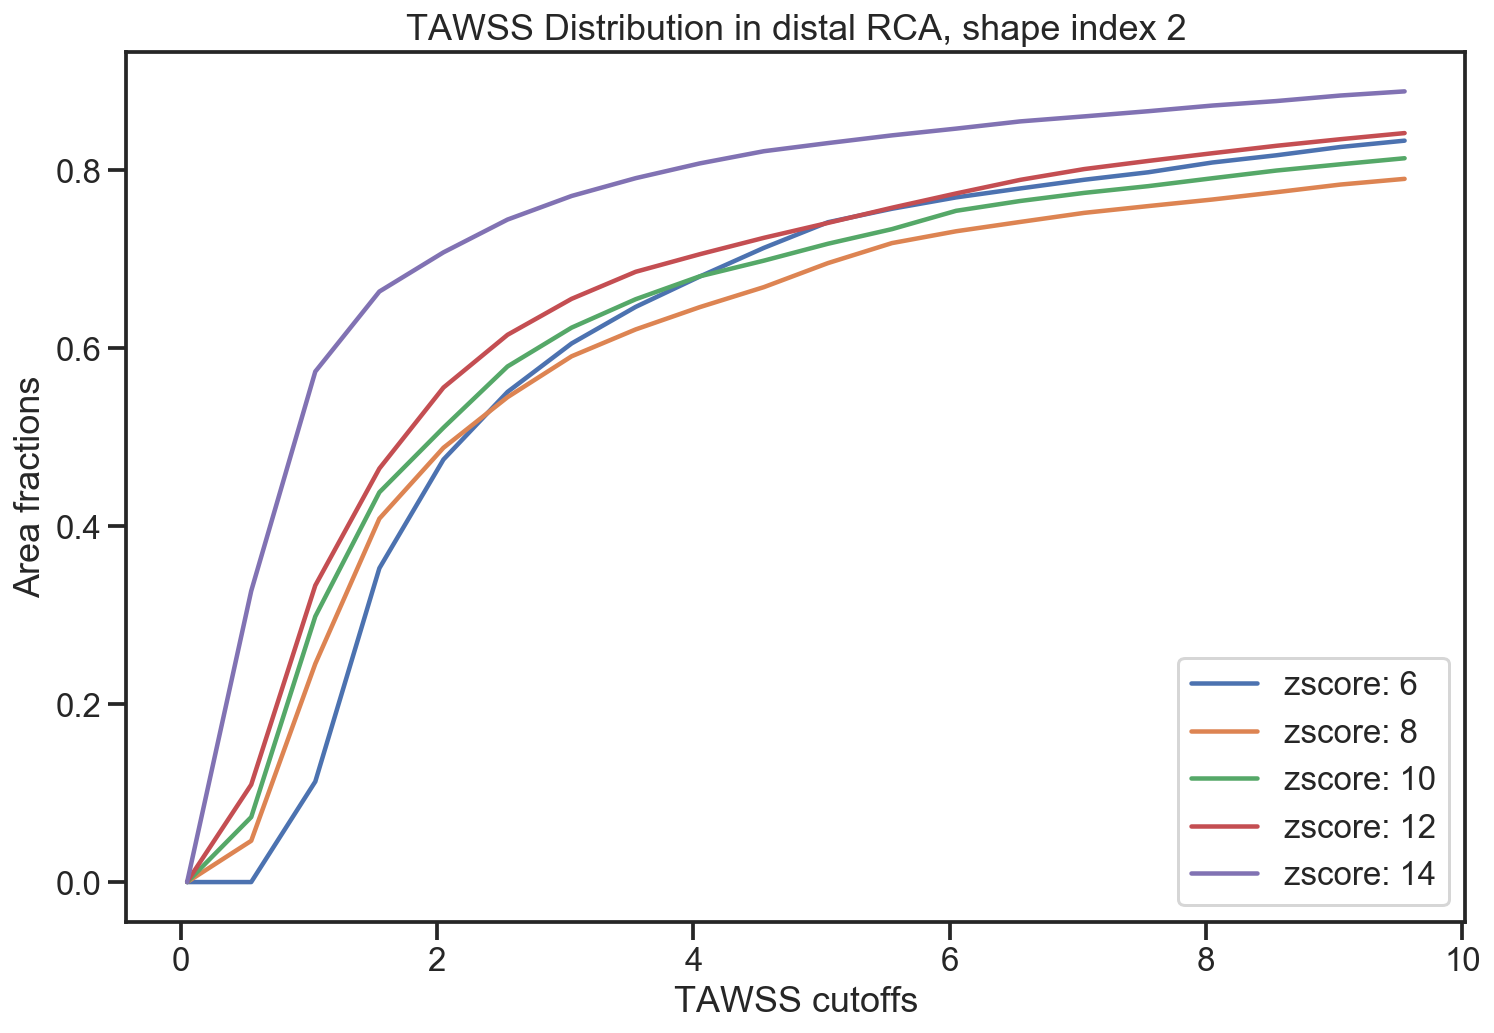

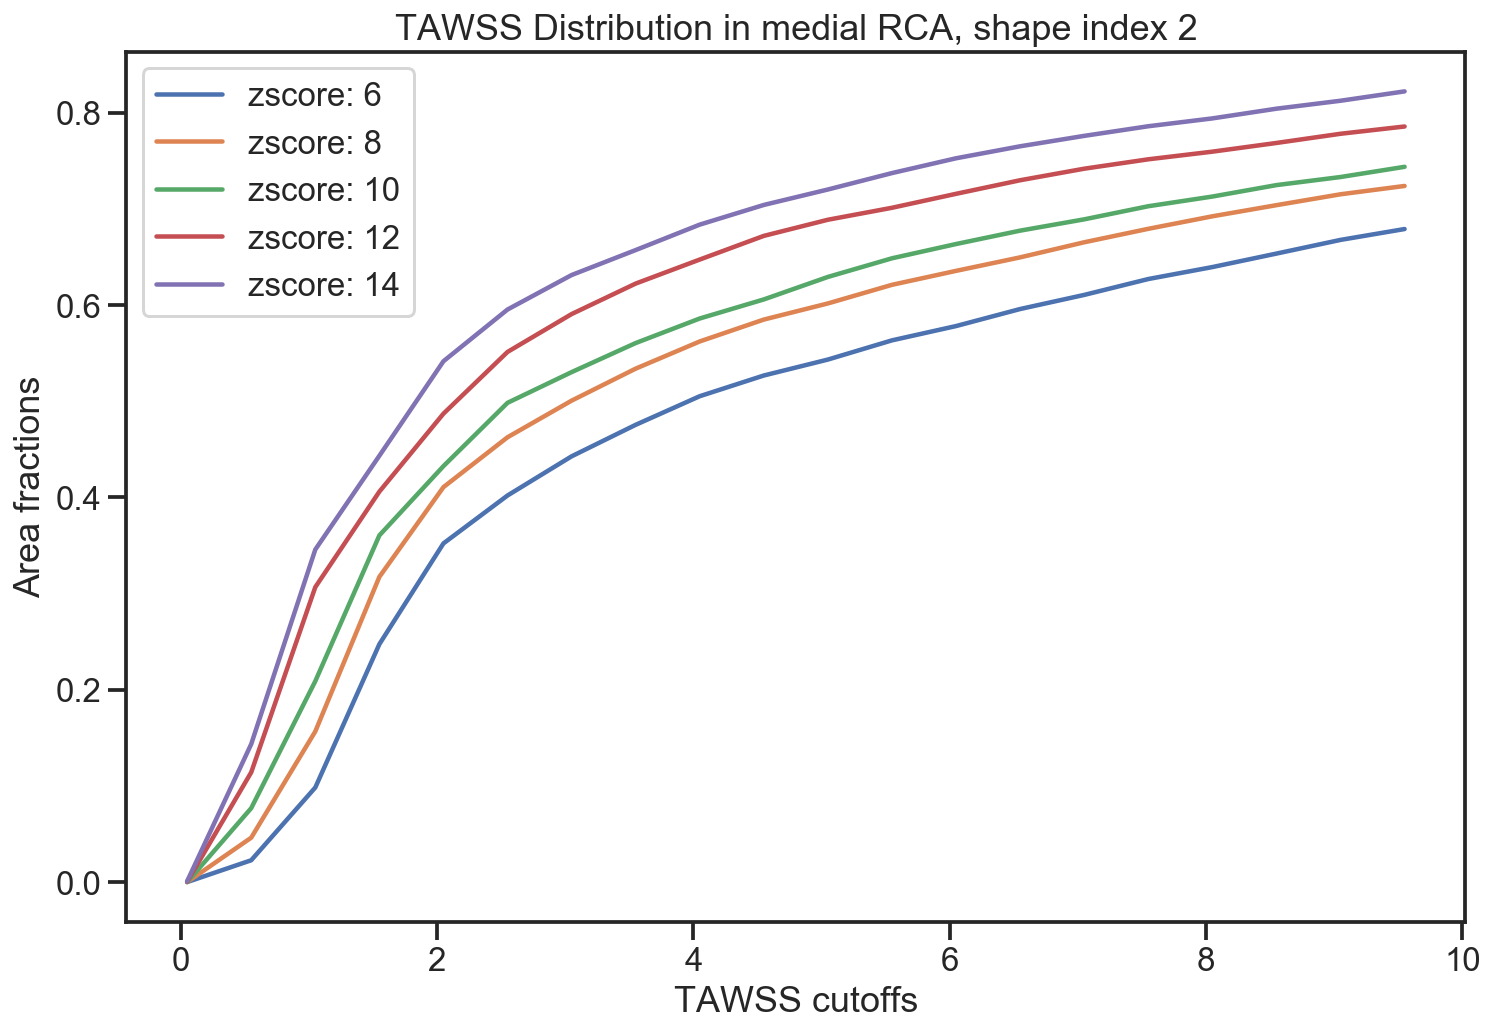

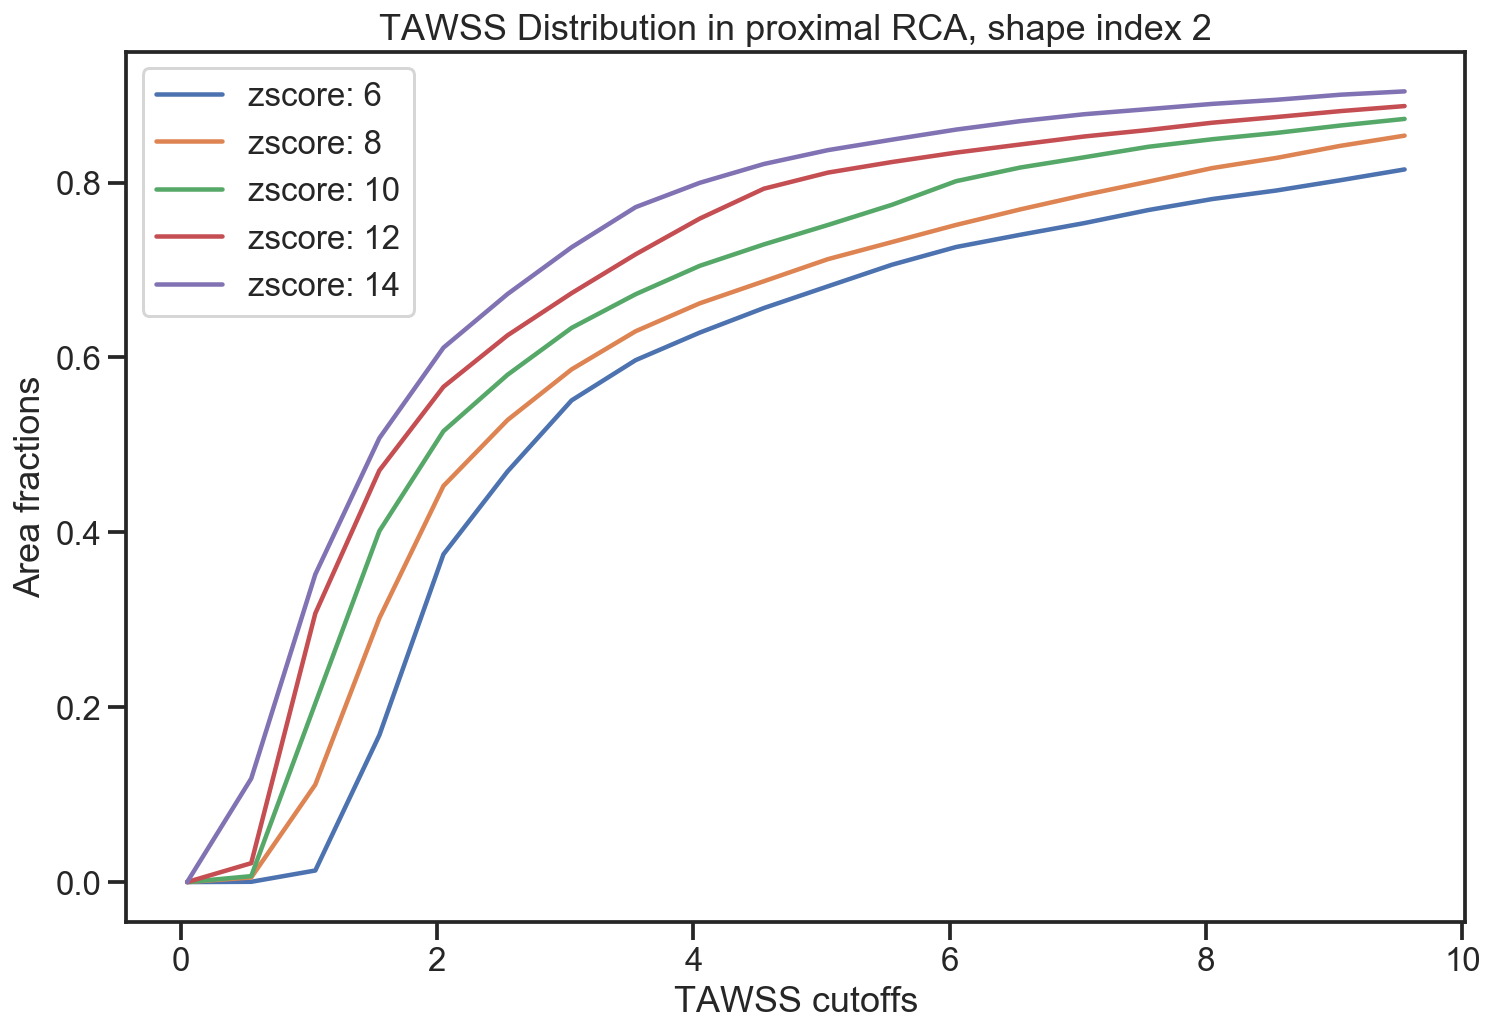

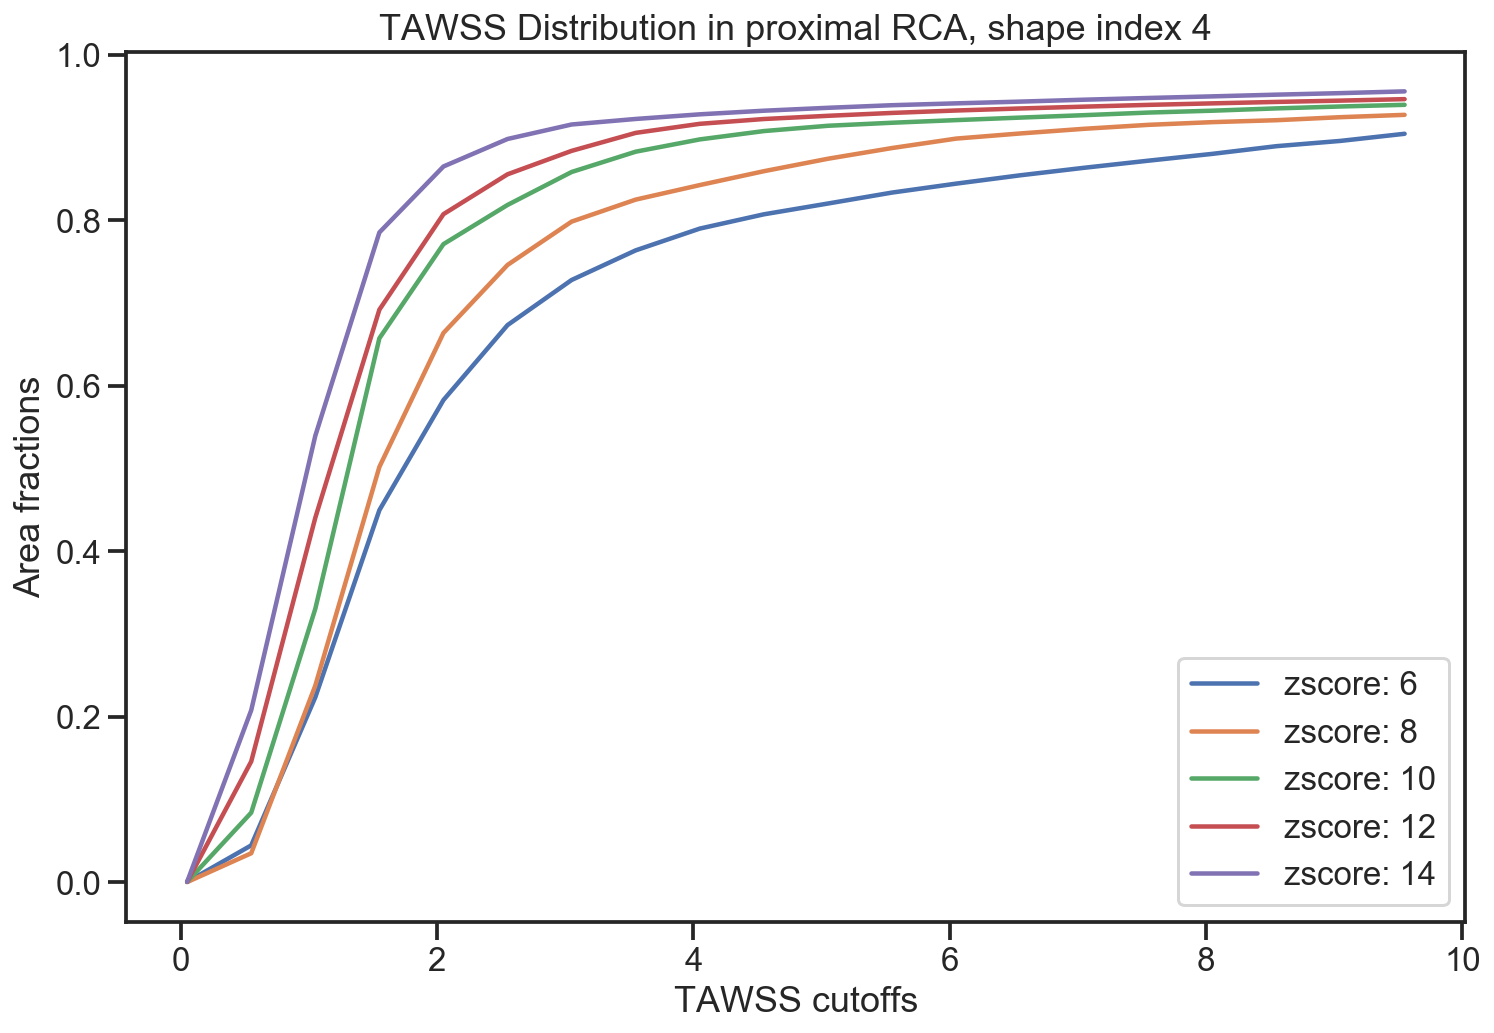

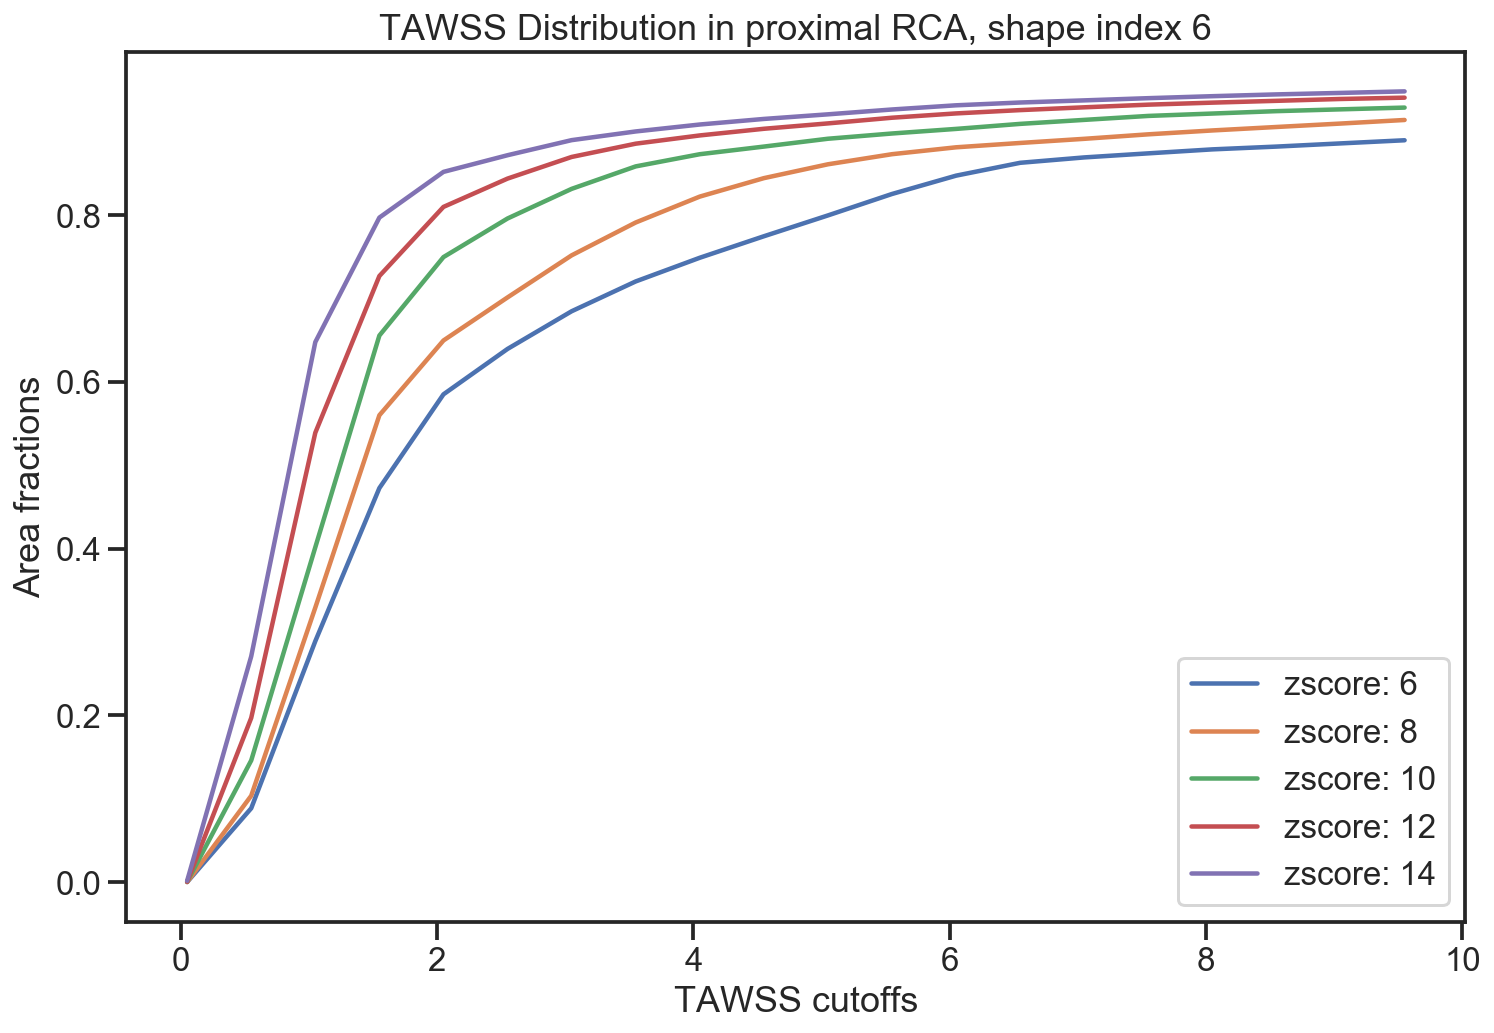

In [7]:
threshold_bounds = np.arange(.05, 10.0, .5)

for shape in shapes: 
    pos_sizes = {'proximal': proximal, 'medial': medial, 'distal': distal}
    if shape == 'ASI6' or shape == 'ASI4': 
        pos_sizes = {'proximal': proximal}
        
    for position, size_list in pos_sizes.iteritems():
        plt.figure(figsize=(12,8))
        for i, size in enumerate(size_list):
            fracs = all_area_fractions_right[shape + '_' + size]
            plt.plot(threshold_bounds, fracs, label='zscore: '+str(z_scores[i]))

        plt.legend()
        plt.title('TAWSS Distribution in ' + position + ' ' + vessel[:-1] + ', shape index ' + shape[-1])
        plt.xlabel('TAWSS cutoffs')
        plt.ylabel('Area fractions')
    

Next, examine the distribution of wall shear stress over the cardiac cycle. 

In [8]:
wss_cycle_rca = read_from_file('WSS_CYCLE_RCA')
vtawss_rca = {}


reading structures from pickle
------------------------------


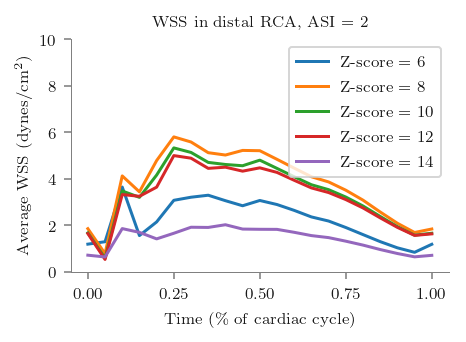

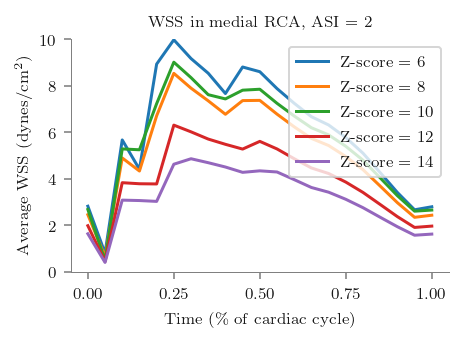

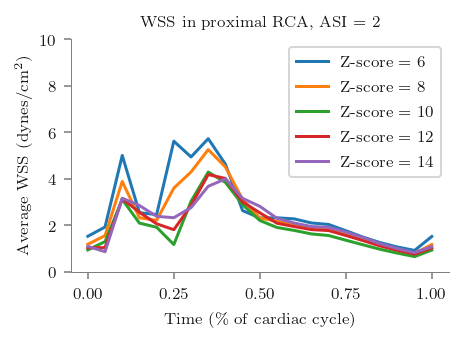

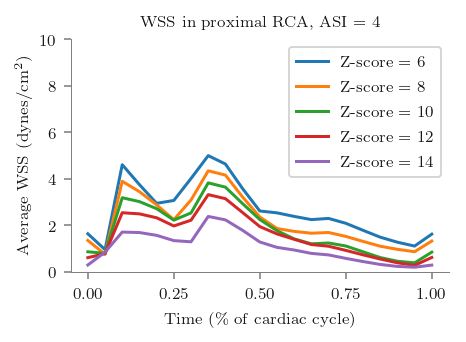

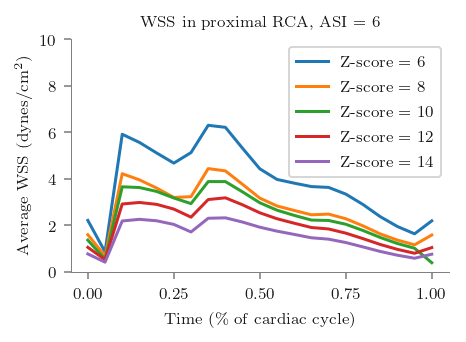

In [134]:
raw_time_steps = np.arange(3000, 4000 + 50, 50)
steps = np.linspace(0.0, 1.0, num=len(raw_time_steps))

for shape in shapes: 
    pos_sizes = {'proximal': proximal, 
                 'medial': medial, 
                 'distal': distal}
    
    if shape == 'ASI6' or shape == 'ASI4': 
        pos_sizes = {'proximal': proximal}
        
    for position, size_list in pos_sizes.iteritems():
        # plt.figure(figsize=(12,12))
        fig = plt.figure()#figsize=(8,6))
        ax = fig.add_subplot(1,1,1)
        format_axes(ax)
        
        for i, size in enumerate(size_list):
            wss, vtawss_rca[shape + '_' + size] = wss_cycle_rca[shape + '_' + size]
            plt.plot(steps, wss, label='Z-score = '+str(z_scores[i]))

        plt.legend(loc='upper right')
        plt.title('WSS in ' + position + ' ' + vessel[:-1] +', ASI = ' + shape[-1])
        plt.xlabel(r'Time ($\%$ of cardiac cycle)')
        plt.xticks([0, .25, .5, .75, 1.])
        plt.ylabel(r'Average WSS (dynes/cm$^2$) ')
        plt.ylim(0, 10)
        plt.savefig("../figures/wss_time_{}_shape{}.eps".format(position, shape[-1]), bbox_inches="tight")

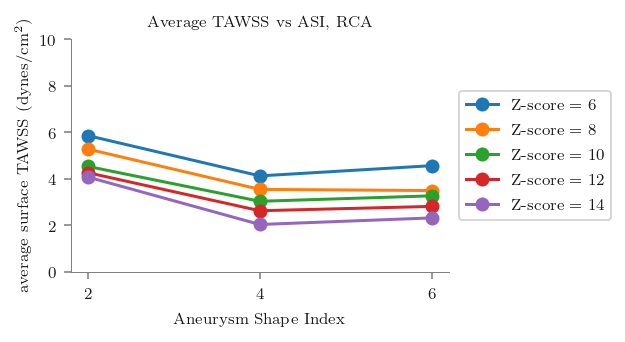

In [119]:
labels = ['prox', 'med', 'dist']
plotted_z_scores = [6, 8, 10, 12, 14]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
format_axes(ax)

for k, size in enumerate(proximal):  
    vtawss_surface_averages = np.zeros(len(shapes))
    for c, shape in enumerate(shapes):
        vtawss_surface_averages[c] = vtawss_rca[shape + '_' + size]
    
    ax.plot([ 2, 4, 6], vtawss_surface_averages, label='Z-score = ' + str(plotted_z_scores[k]), marker='o')
    
# for k, size in enumerate(medial): 
#     vtawss_surface_averages = np.zeros(len(['ASI2']))
#     vtawss_surface_averages[0]= vtawss_rca['ASI2' + '_' + size]
#     ax.plot(['ASI2'], vtawss_surface_averages, label='med z-score = ' + str(plotted_z_scores[k]), marker='p')
    
# for k, size in enumerate(distal): 
#     vtawss_surface_averages = np.zeros(len(['ASI2']))
#     vtawss_surface_averages[0] = vtawss_rca['ASI2' + '_' + size]
#     ax.plot(['ASI2'], vtawss_surface_averages, label='dist z-score = ' + str(plotted_z_scores[k]), marker='s')
    
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(loc="right", bbox_to_anchor=(1.45, .5))
plt.xlabel('Aneurysm Shape Index')
plt.xticks([2, 4, 6])
plt.ylabel(r'average surface TAWSS (dynes/cm$^2$)')
plt.title('Average TAWSS vs ASI, ' + vessel[:-1] )
plt.ylim(0, 10)
plt.savefig("../figures/avg_tawss_asi_right.eps", bbox_inches="tight")
plt.show()


In [11]:
print all_area_fractions_right

{'ASI2_m4': array([3.72162525e-04, 1.14124288e-01, 3.06686455e-01, 4.06008104e-01,
       4.87070721e-01, 5.51253026e-01, 5.90609589e-01, 6.22333537e-01,
       6.47313816e-01, 6.71925232e-01, 6.88699539e-01, 7.01141705e-01,
       7.15657352e-01, 7.29772870e-01, 7.41783178e-01, 7.51545708e-01,
       7.59493055e-01, 7.68537314e-01, 7.78094394e-01, 7.85667314e-01]), 'ASI2_m5': array([0.00084155, 0.14348627, 0.34576971, 0.4433132 , 0.54157243,
       0.59535192, 0.63120123, 0.65717592, 0.68363758, 0.70408644,
       0.72015319, 0.73722505, 0.7526097 , 0.76507441, 0.77591412,
       0.78591889, 0.79407512, 0.80417773, 0.81243708, 0.82218168]), 'ASI2_m1': array([0.        , 0.02268436, 0.09832771, 0.2473909 , 0.35214442,
       0.40197653, 0.44269403, 0.47546733, 0.50521035, 0.52674416,
       0.54332047, 0.56329128, 0.5781512 , 0.59586567, 0.61053036,
       0.627053  , 0.63948995, 0.65351283, 0.66773385, 0.67904487]), 'ASI2_m2': array([0.        , 0.04616233, 0.15663001, 0.31738979, 0.4

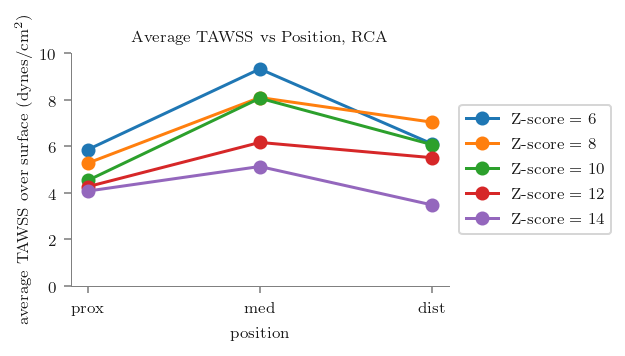

In [120]:
labels = ['prox', 'med', 'dist']
plotted_z_scores = ['6', '8', '10', '12', '14']

cur_asi = 'ASI2'

        
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
format_axes(ax)
vals = np.zeros((len(labels), len(plotted_z_scores), 2))

for i, pos in enumerate([proximal, medial, distal]): 
    for j, (size, z) in enumerate(zip(pos, plotted_z_scores)): 
        vals[i,j,0] = vtawss_rca[cur_asi + '_' + size]
        vals[i,j,1] = all_area_fractions_right[cur_asi + '_' + size][2]


for i, z in enumerate(plotted_z_scores): 
    ax.plot(labels, vals[:,i,0], label='Z-score = ' + str(z), marker='o')

plt.legend(loc='right', bbox_to_anchor=(1.45,.5))
plt.xlabel('position')
ax.set_ylabel(r'average TAWSS over surface (dynes/cm$^2$)')
plt.title('Average TAWSS vs Position, ' + vessel[:-1] )
ax.set_ylim(0, 10)
plt.savefig("../figures/avg_tawss_pos_rca.eps", bbox_inches="tight")
plt.show()

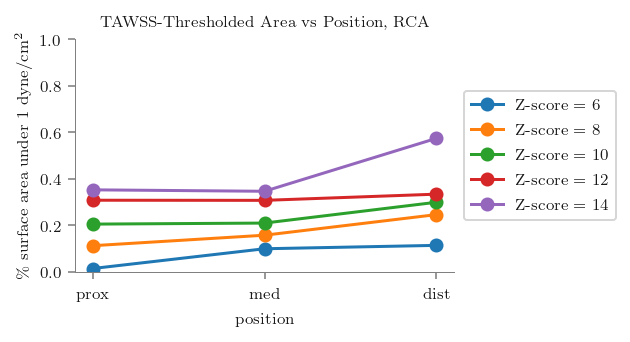

In [121]:
##### labels = ['prox', 'med', 'dist']
plotted_z_scores = ['6', '8', '10', '12', '14']

cur_asi = 'ASI2'

        
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
format_axes(ax)
vals = np.zeros((len(labels), len(plotted_z_scores), 2))

for i, pos in enumerate([proximal, medial, distal]): 
    for j, (size, z) in enumerate(zip(pos, plotted_z_scores)): 
        vals[i,j,0] = vtawss_rca[cur_asi + '_' + size]
        vals[i,j,1] = all_area_fractions_right[cur_asi + '_' + size][2]


for i, z in enumerate(plotted_z_scores): 
    ax.plot(labels, vals[:,i,1], label='Z-score = ' + str(z), marker='o')


# plt.legend(loc='right', bbox_to_anchor=(1.32,1))
plt.legend(loc='right', bbox_to_anchor=(1.45, .5))
plt.xlabel('position')
ax.set_ylabel(r'$\%$ surface area under 1 dyne/cm$^2$')
plt.title('TAWSS-Thresholded Area vs Position, ' + vessel[:-1] )
ax.set_ylim(0, 1)
plt.savefig("../figures/thresh_area_rca_pos.eps", bbox_inches="tight")
plt.show()

In [13]:
osi_areas_rca = read_from_file('OSI_THRESHOLD_AREA_RCA')
osi_rca = {}

reading structures from pickle
------------------------------


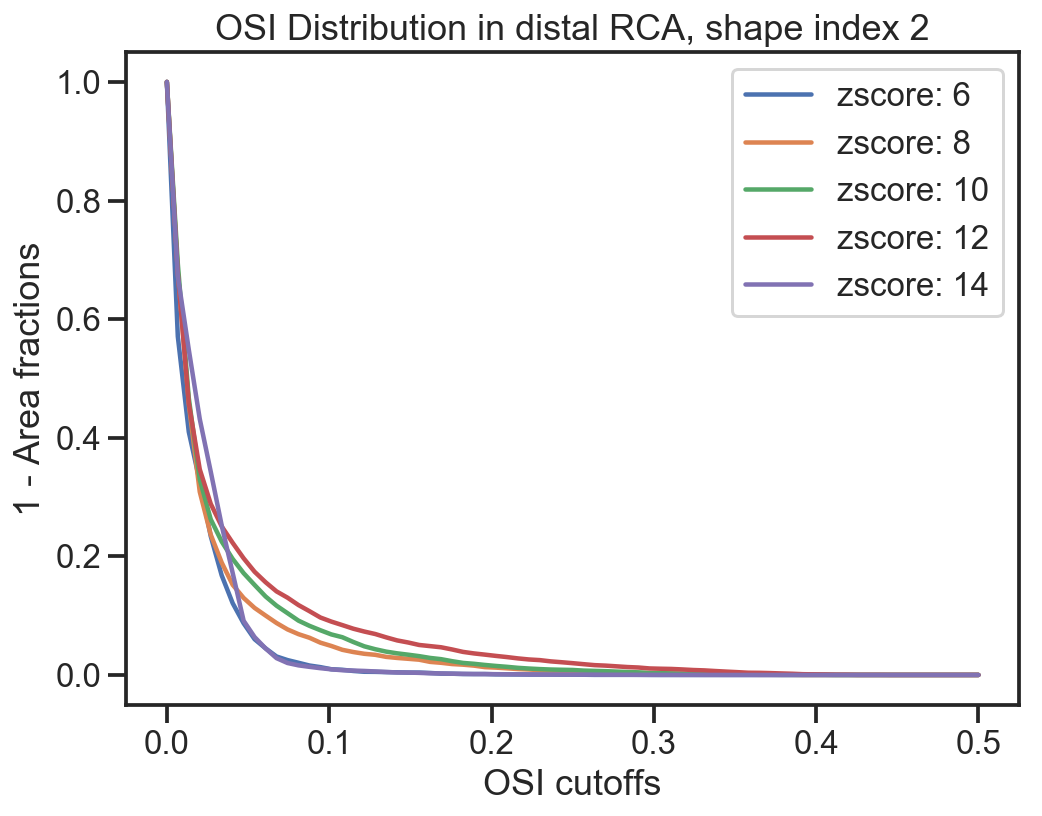

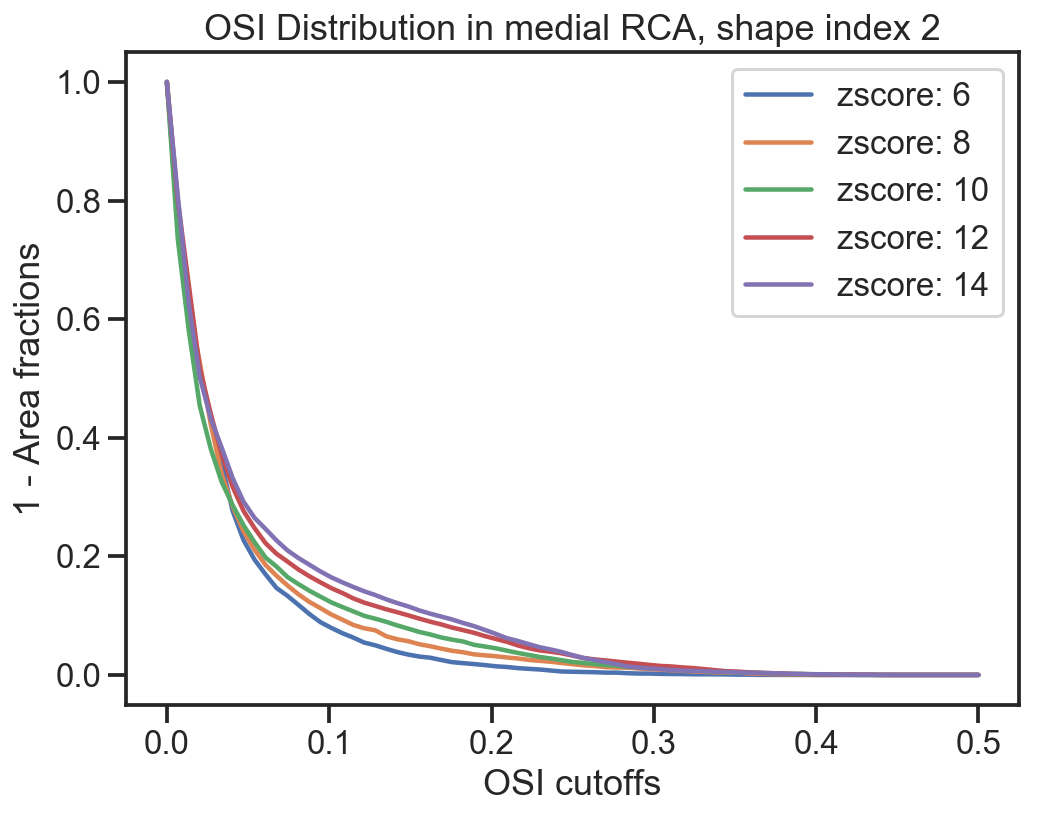

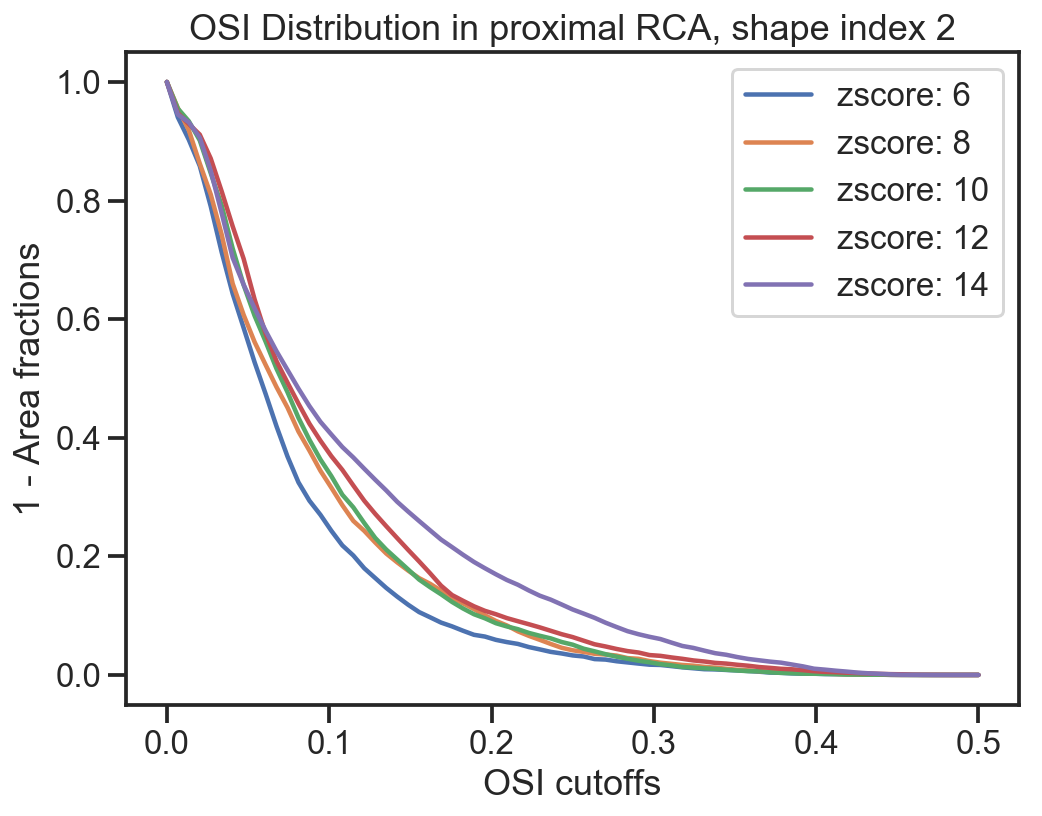

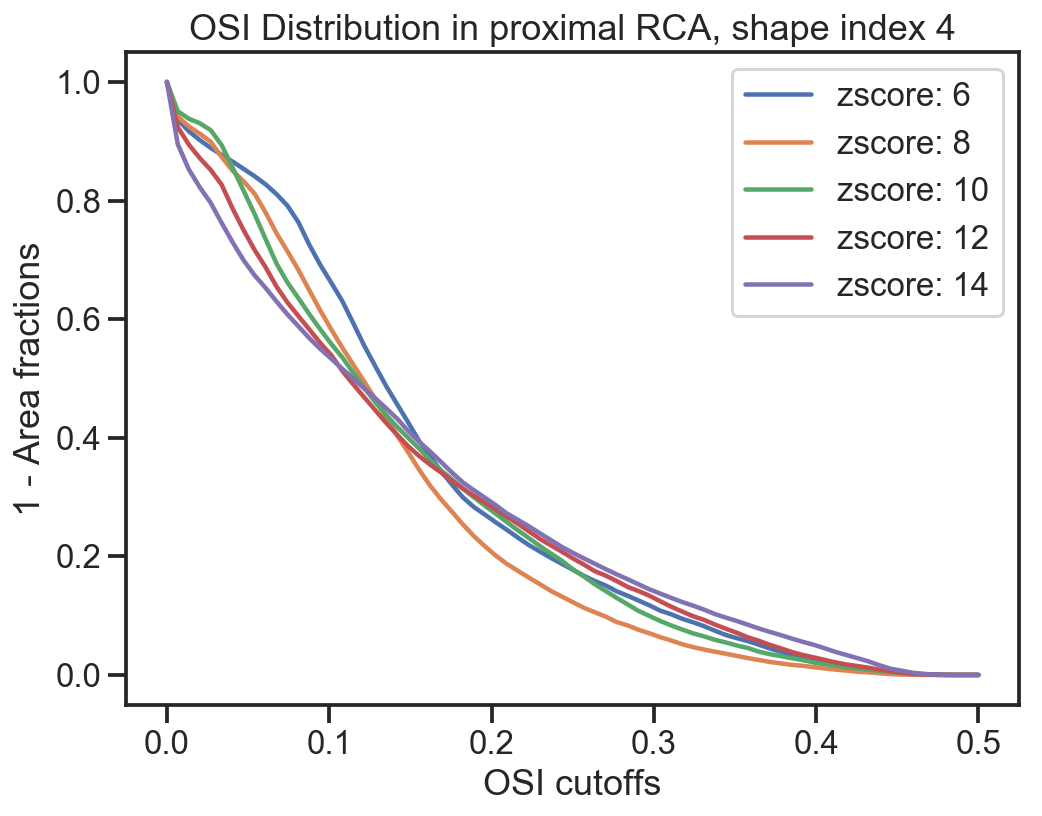

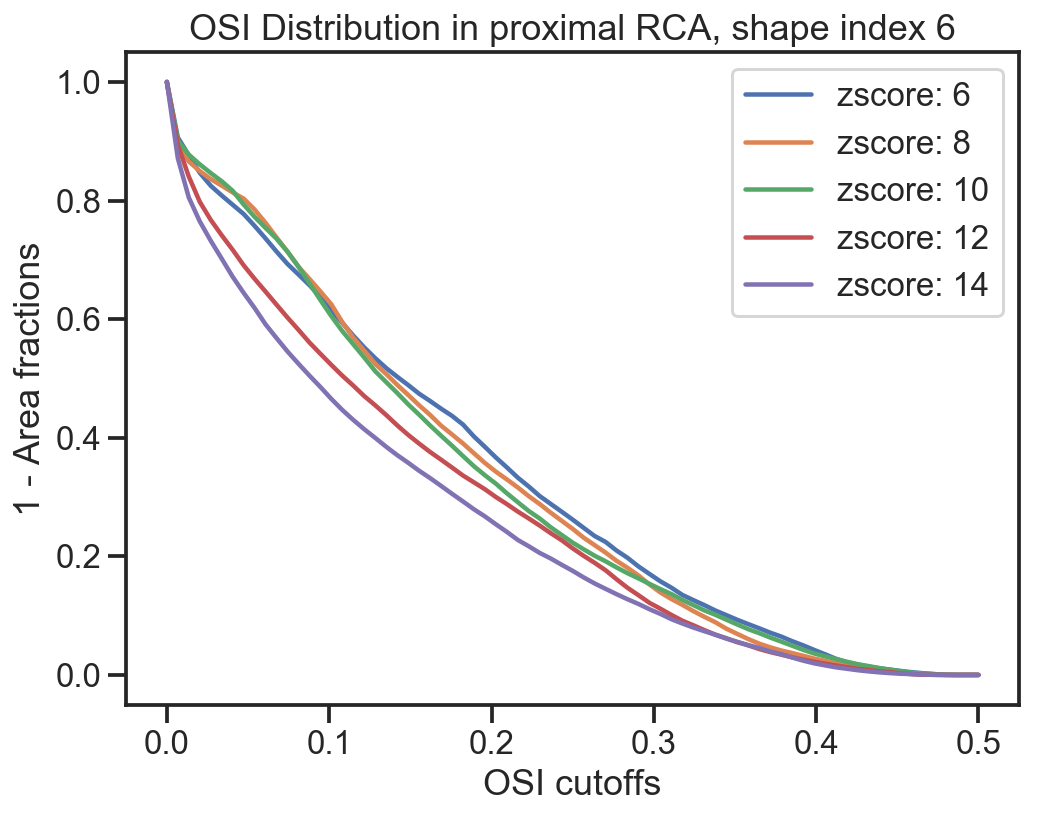

In [14]:
threshold_bounds = np.linspace(0, .5, num=75)

for shape in shapes: 
    pos_sizes = {'proximal': proximal, 'medial': medial, 'distal': distal}
    if shape == 'ASI6' or shape == 'ASI4': 
        pos_sizes = {'proximal': proximal}
        
    for position, size_list in pos_sizes.iteritems():
        plt.figure(figsize=(8,6))
        for i, size in enumerate(size_list):
            fracs = osi_areas_rca[shape + '_' + size]
            plt.plot(threshold_bounds, fracs, label='zscore: '+str(z_scores[i]))

        plt.legend()
        plt.title('OSI Distribution in ' + position + ' ' + vessel[:-1] + ', shape index ' + shape[-1])
        plt.xlabel('OSI cutoffs')
        plt.ylabel('1 - Area fractions')

### Moving onto the left side. 

In [103]:
vessel = 'LAD/'
shapes = ['ASI2', 'ASI4', 'ASI6']
z_scores = [6, 8, 10, 12, 14]
left_positions = ['lad1', 'lad2', 'lad3', 'lad4', 'lad5']

In [71]:
all_area_fractions_lad = read_from_file('WSS_THRESHOLD_AREA_LAD')

reading structures from pickle
------------------------------


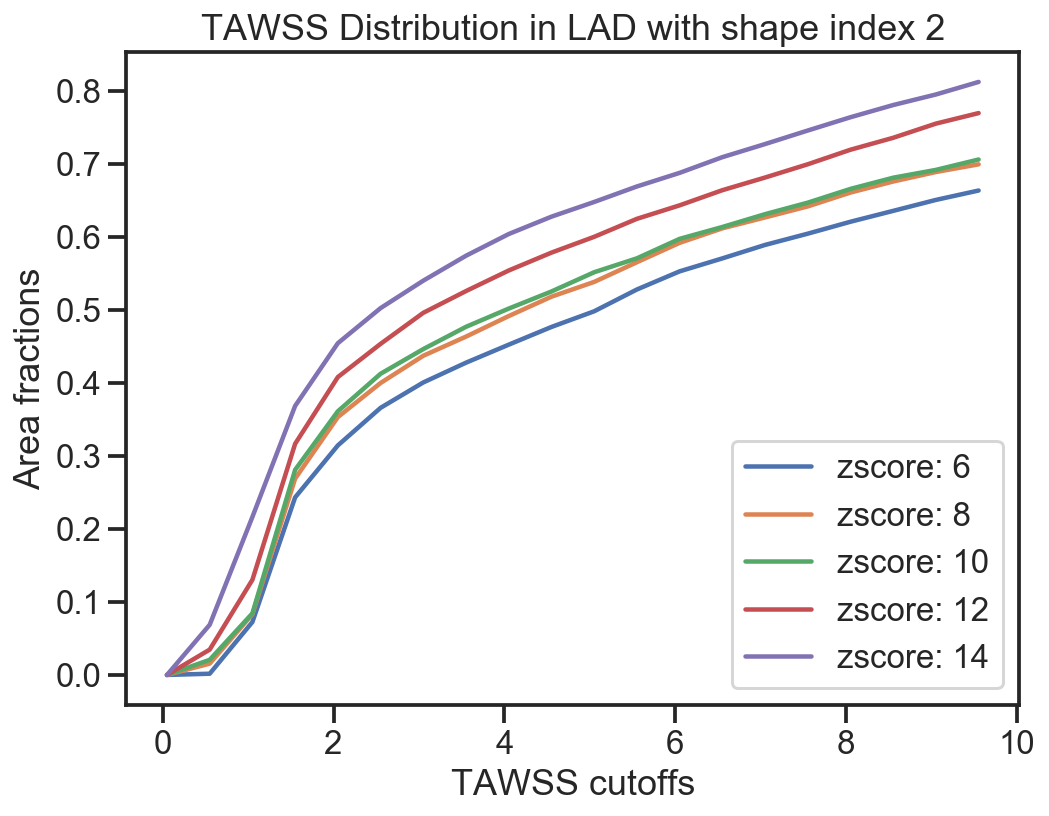

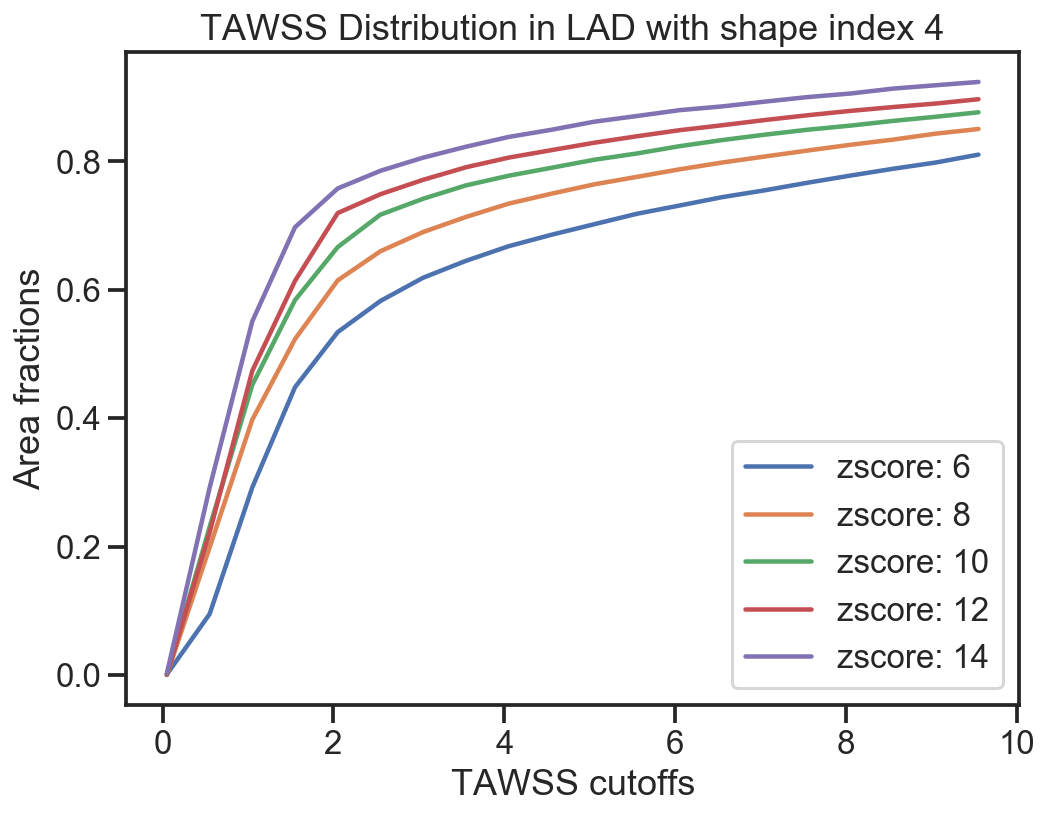

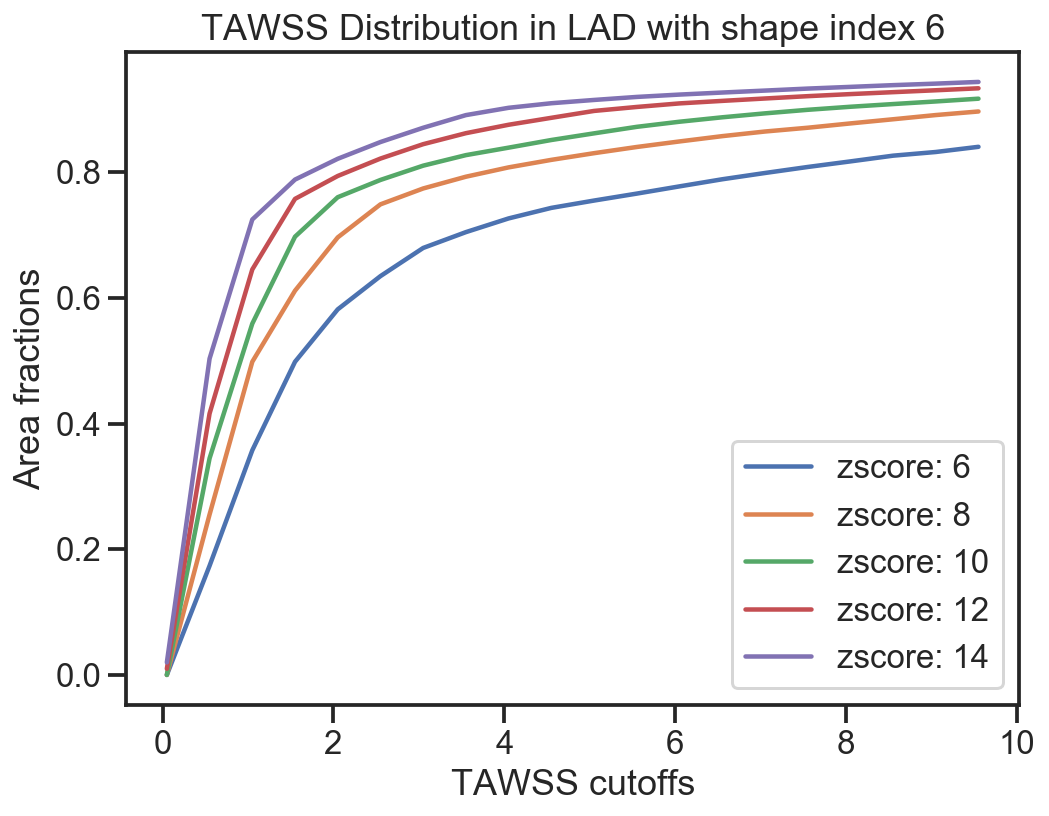

In [17]:
threshold_bounds = np.arange(.05, 10.0, .5)

for shape in shapes: 
    pos_sizes = {'LAD': ['lad1', 'lad2', 'lad3','lad4','lad5']}
    # if shape == 'ASI6': pos_sizes = {'LAD': ['lad2', 'lad3','lad4','lad5']}
        
    for position, size_list in pos_sizes.iteritems():
        # plt.figure(figsize=(12,12))
        plt.figure(figsize=(8,6))
        for i, size in enumerate(size_list):
            fracs = all_area_fractions_lad[shape + '_' + size]
            plt.plot(threshold_bounds, fracs, label='zscore: '+str(z_scores[i]))

        plt.legend()
        plt.title('TAWSS Distribution in ' + vessel[:-1] + ' with shape index ' + shape[-1])
        plt.xlabel('TAWSS cutoffs')
        plt.ylabel('Area fractions')

In [18]:
wss_cycle_lad = read_from_file('WSS_CYCLE_LAD')
vtawss_lad = {}

reading structures from pickle
------------------------------


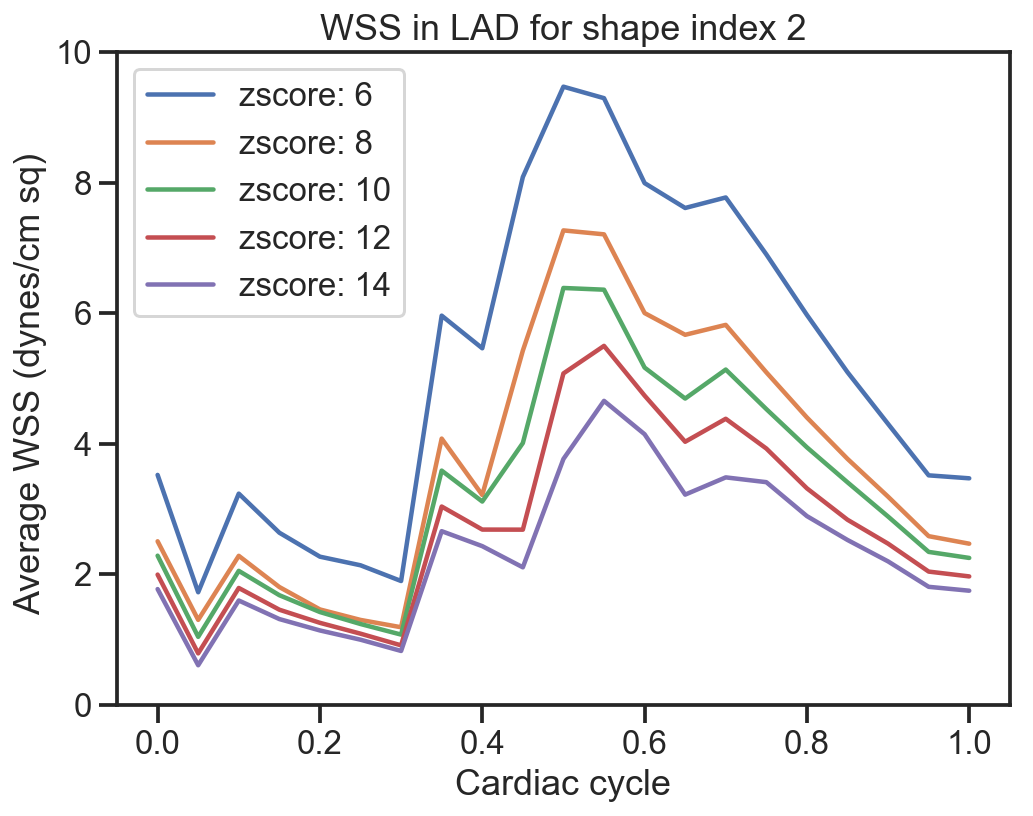

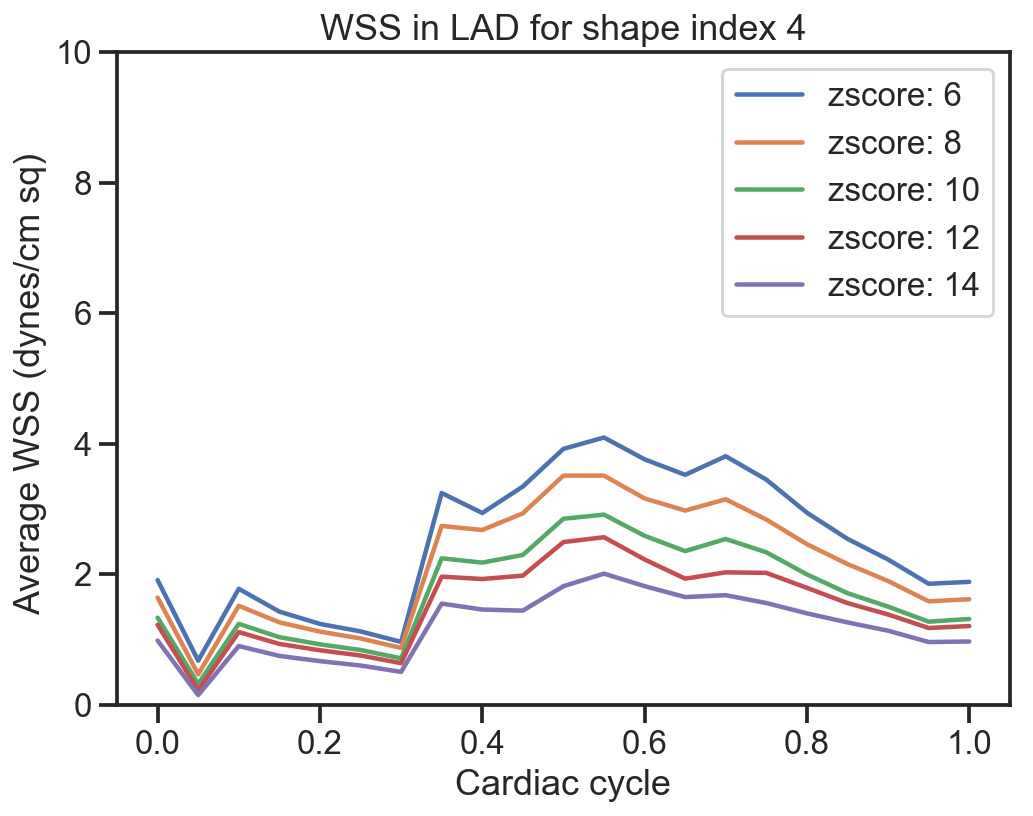

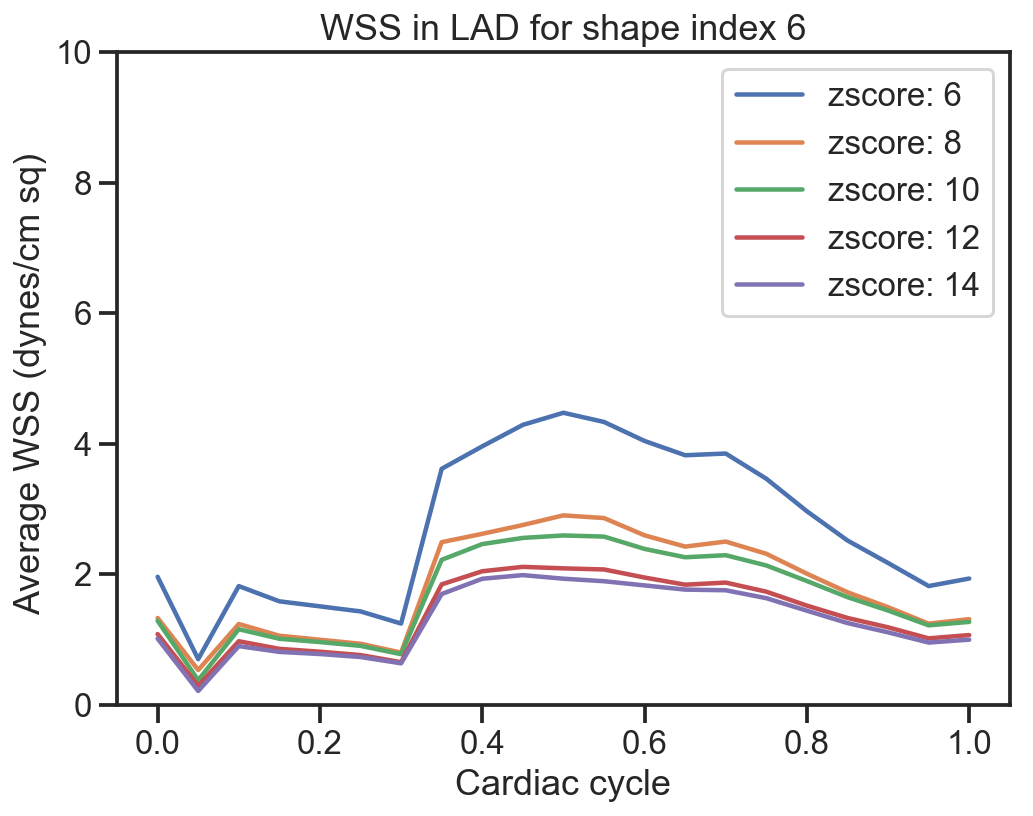

In [19]:
raw_time_steps = np.arange(3000, 4000 + 50, 50)
steps = np.linspace(0.0, 1.0, num=len(raw_time_steps))

for shape in shapes: 
    pos_sizes = {'LAD': ['lad1', 'lad2', 'lad3','lad4','lad5']}
        
    for position, size_list in pos_sizes.iteritems():
        # plt.figure(figsize=(12,12))
        plt.figure(figsize=(8,6))
        for i, size in enumerate(size_list):
            wss, vtawss_lad[shape + '_' + size] = wss_cycle_lad[shape + '_' + size]
            plt.plot(steps, wss, label='zscore: '+str(z_scores[i]))

        plt.legend()
        plt.title('WSS in ' + vessel[:-1] + ' for shape index ' + shape[-1])
        plt.xlabel(r'Time ($\%$ of cardiac cycle)')
        plt.xticks([0, .25, .5, .75, 1.])
        plt.ylabel('Average WSS (dynes/cm sq) ')
        plt.ylim(0, 10)

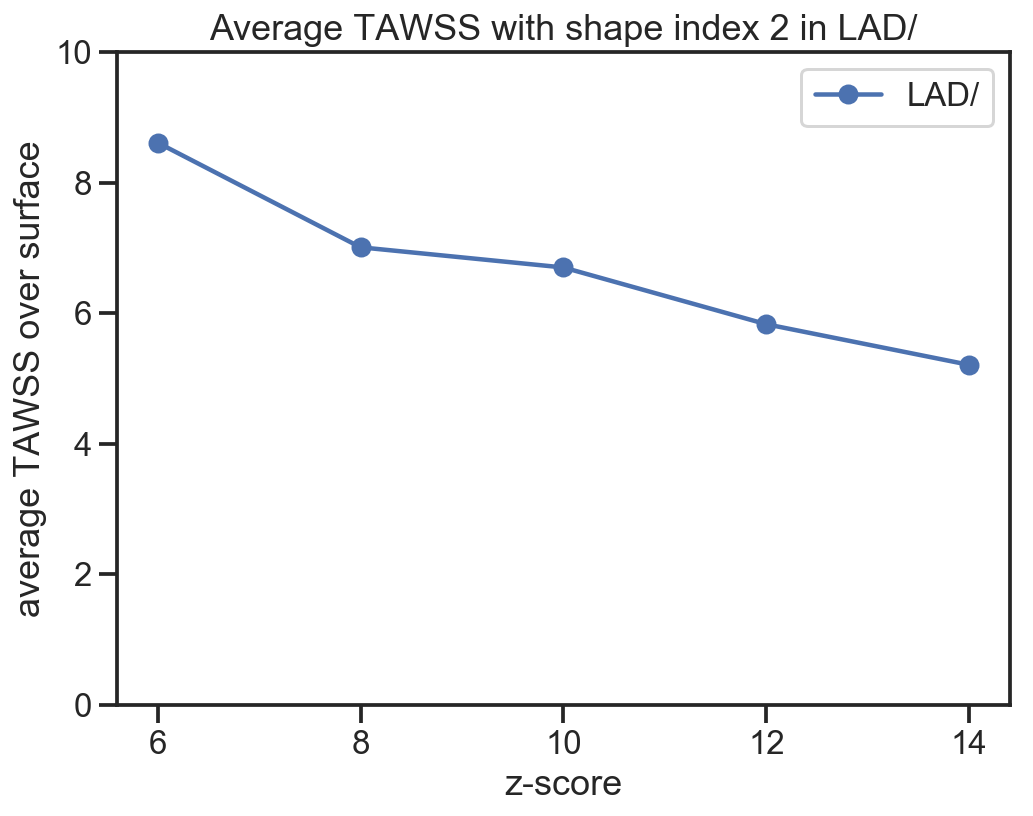

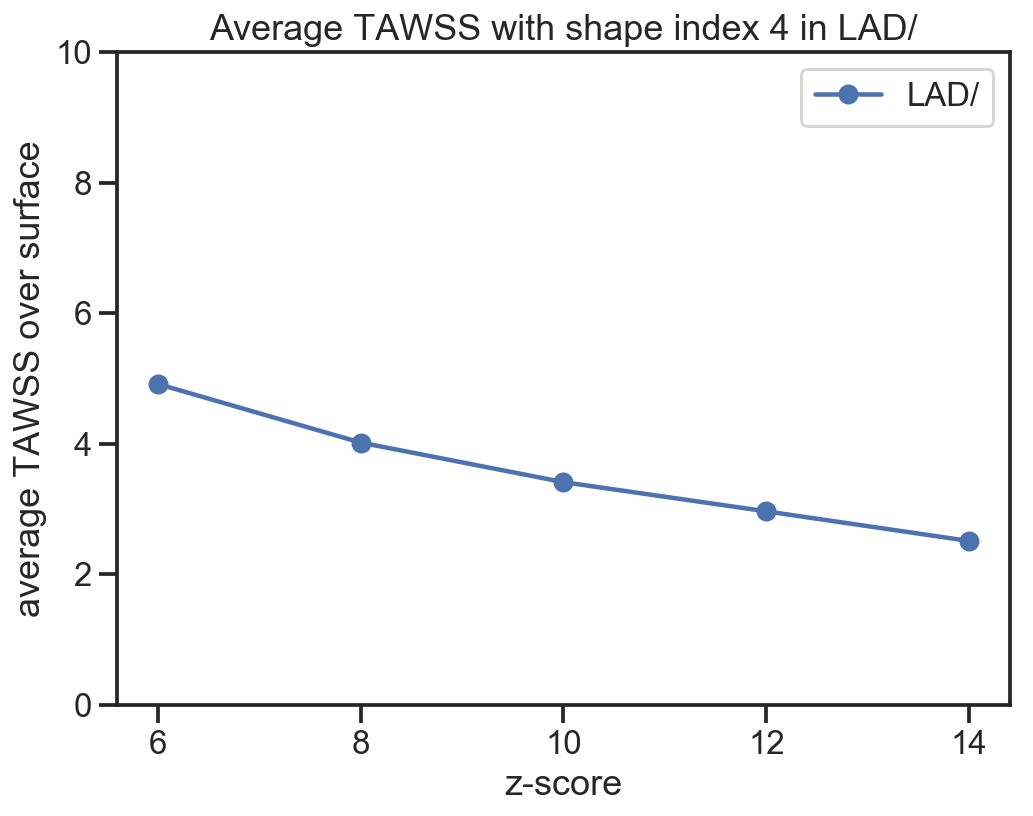

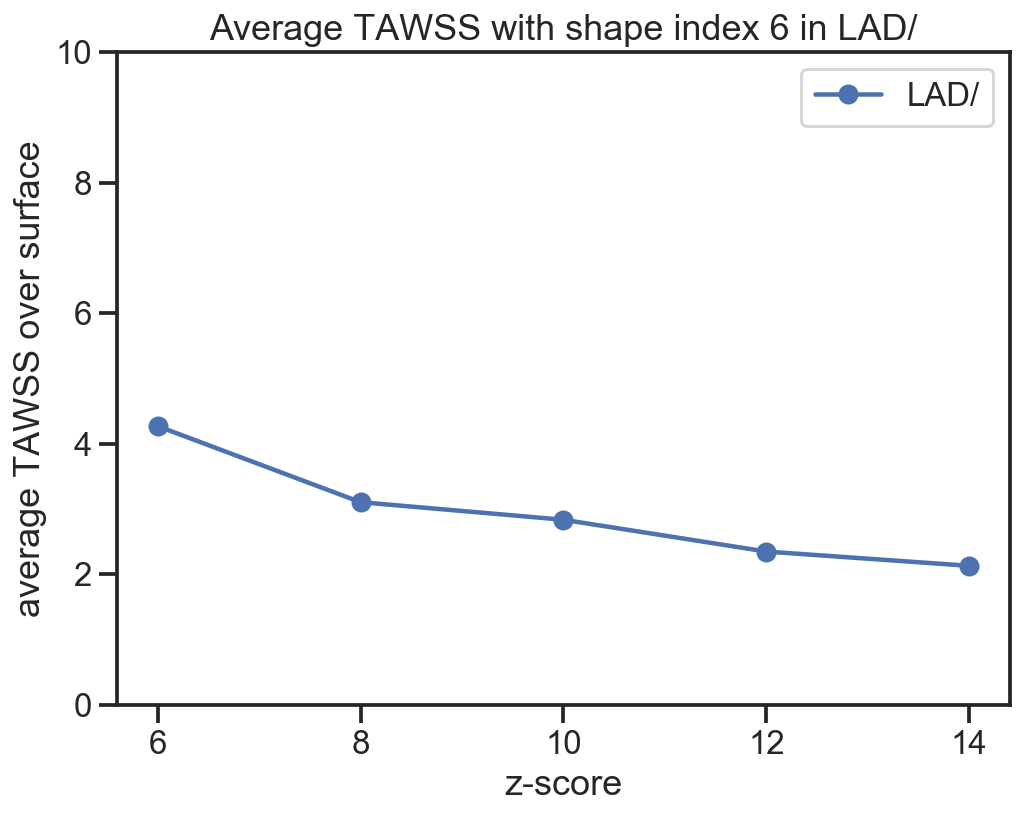

In [20]:
for shape in shapes: 
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    loc_set = left_positions
    vtawss_surface_averages = np.zeros(len(loc_set))
    for k, size in enumerate(loc_set):
        vtawss_surface_averages[k] = vtawss_lad[shape + '_' + size]

    ax.plot(z_scores, vtawss_surface_averages, label=vessel, marker='o')
    plt.legend()
    plt.xlabel('z-score')
    plt.ylabel('average TAWSS over surface')
    plt.title('Average TAWSS with shape index ' + shape[-1] + ' in ' + vessel)
    plt.ylim(0, 10)
    ax.set_xticks(z_scores)

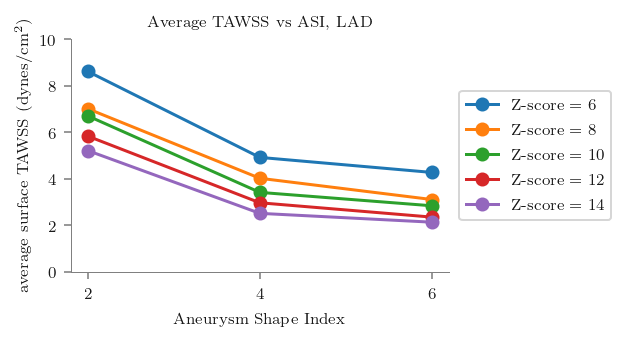

In [115]:
plotted_z_scores = [6, 8, 10, 12, 14]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
format_axes(ax)

for k, size in enumerate(left_positions):  
    vtawss_surface_averages = np.zeros(len(shapes))
    for c, shape in enumerate(shapes):
        vtawss_surface_averages[c] = vtawss_lad[shape + '_' + size]
    
    ax.plot([2, 4, 6], vtawss_surface_averages, label='Z-score = ' + str(plotted_z_scores[k]), marker='o')
    
plt.legend(loc="right", bbox_to_anchor=(1.45, .5))
plt.xlabel('Aneurysm Shape Index')
plt.xticks([2, 4, 6])
plt.ylabel(r'average surface TAWSS (dynes/cm$^2$)')
plt.title('Average TAWSS vs ASI, ' +  vessel[:-1] )
plt.ylim(0, 10)
plt.savefig("../figures/avg_tawss_asi_left.eps", bbox_inches="tight")
plt.show()

In [22]:
osi_areas_lad = read_from_file('OSI_THRESHOLD_AREA_LAD')
osi_lad = {}

reading structures from pickle
------------------------------


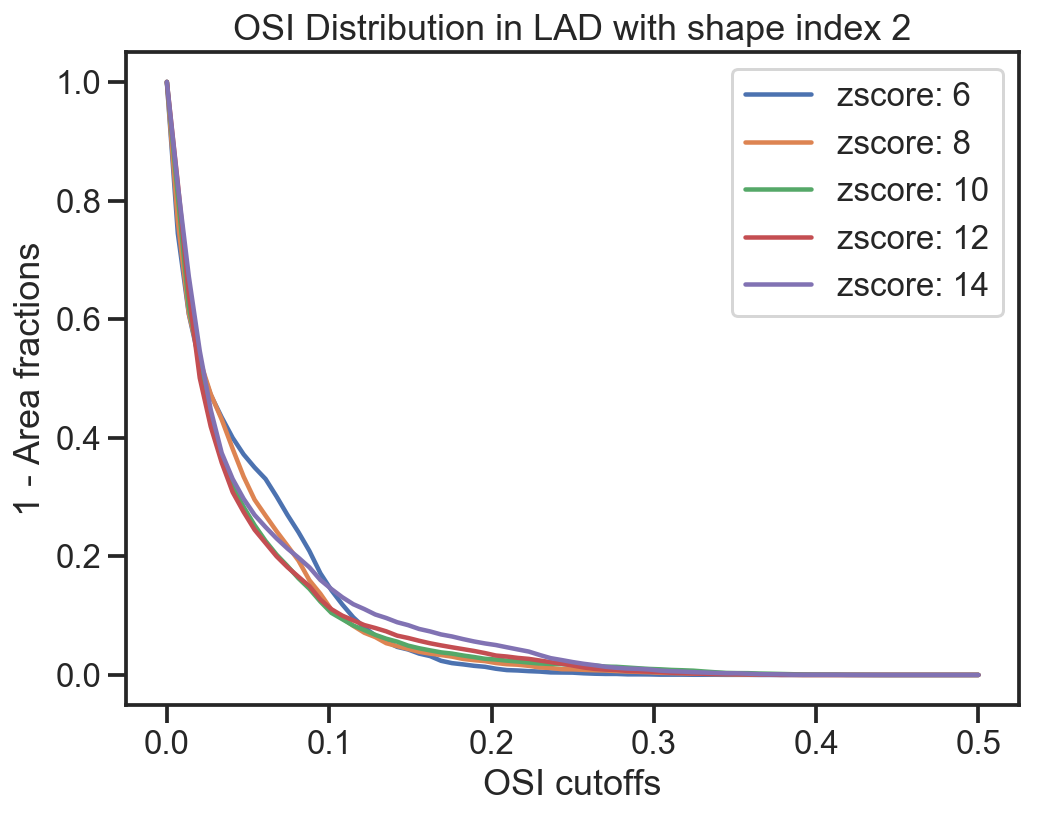

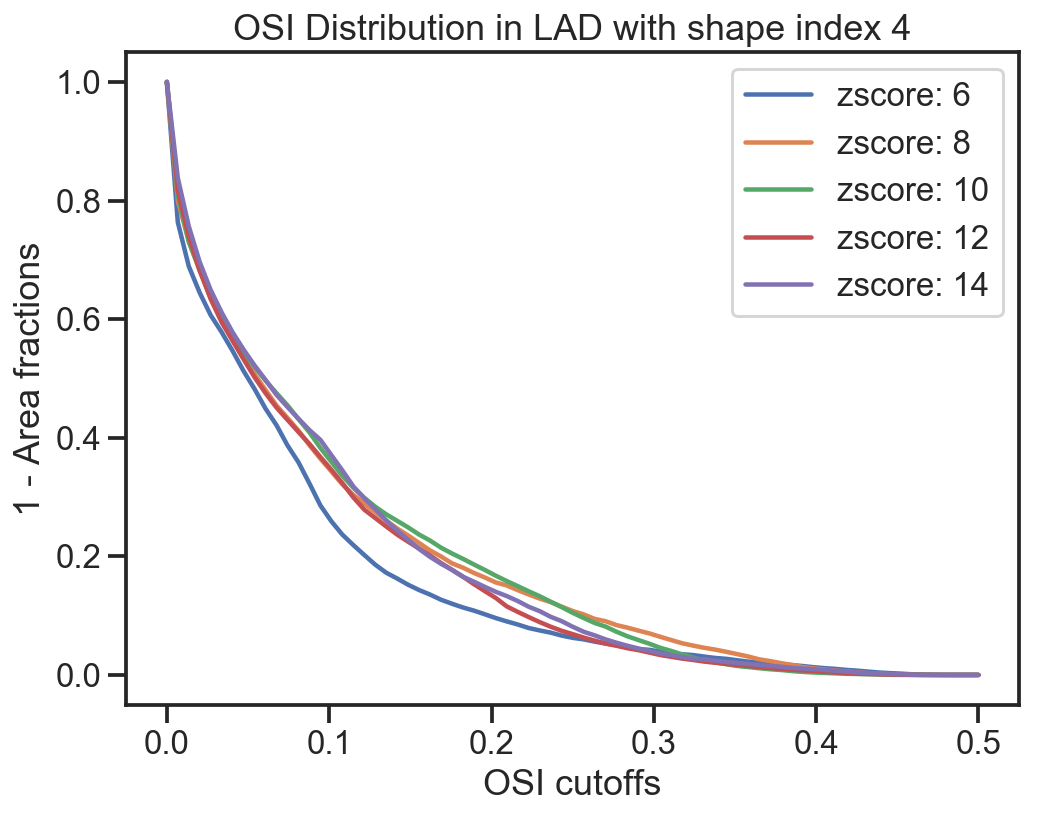

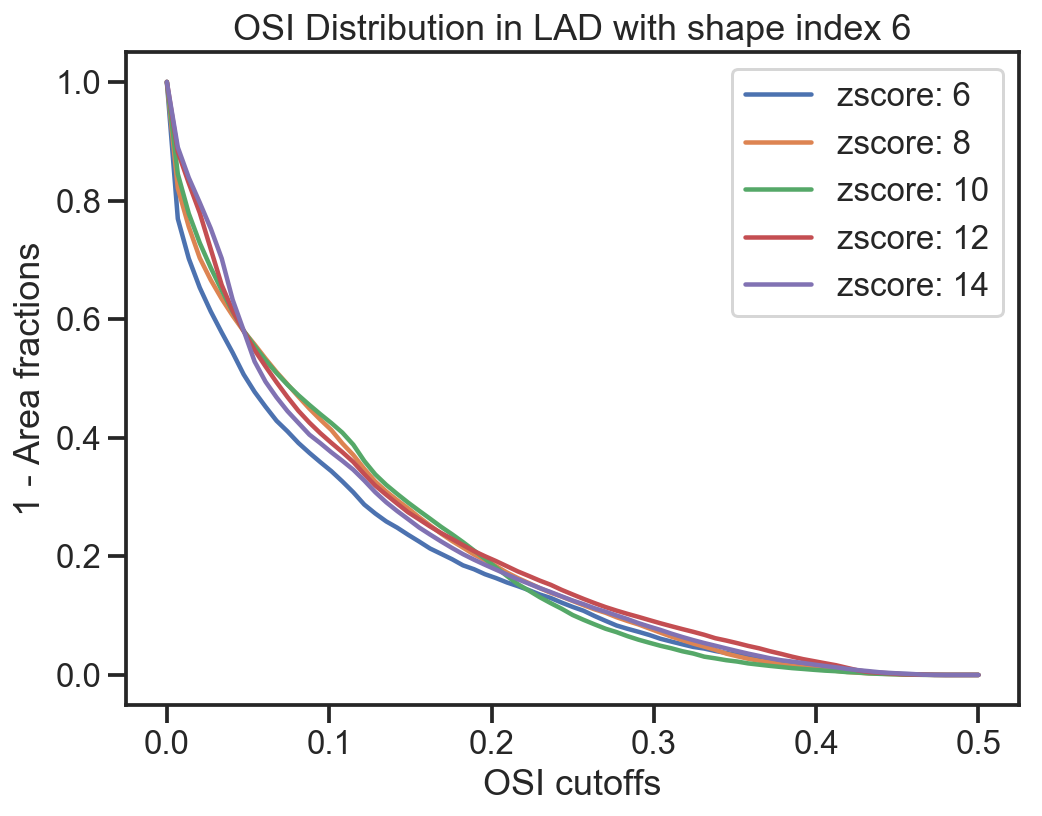

In [23]:
threshold_bounds = np.linspace(0, .5, num=75)

for shape in shapes: 
    pos_sizes = {'LAD': ['lad1', 'lad2', 'lad3','lad4','lad5']}
    # if shape == 'ASI6': pos_sizes = {'LAD': ['lad2', 'lad3','lad4','lad5']}
        
    for position, size_list in pos_sizes.iteritems():
        # plt.figure(figsize=(12,12))
        plt.figure(figsize=(8,6))
        for i, size in enumerate(size_list):
            fracs = osi_areas_lad[shape + '_' + size]
            plt.plot(threshold_bounds, fracs, label='zscore: '+str(z_scores[i]))

        plt.legend()
        plt.title('OSI Distribution in ' + vessel[:-1] + ' with shape index ' + shape[-1])
        plt.xlabel('OSI cutoffs')
        plt.ylabel('1 - Area fractions')
  

#### Summary of average TAWSS with respect to z-score for each shape index

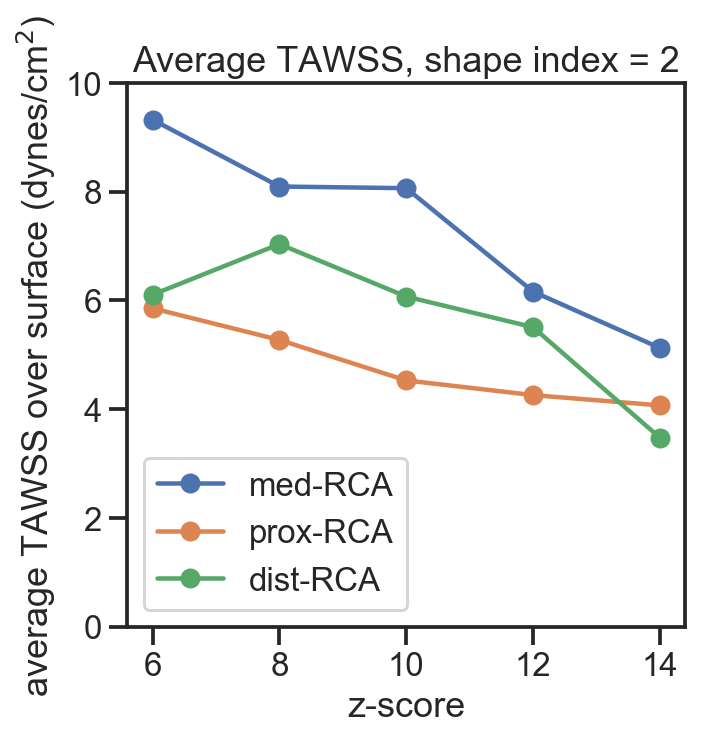

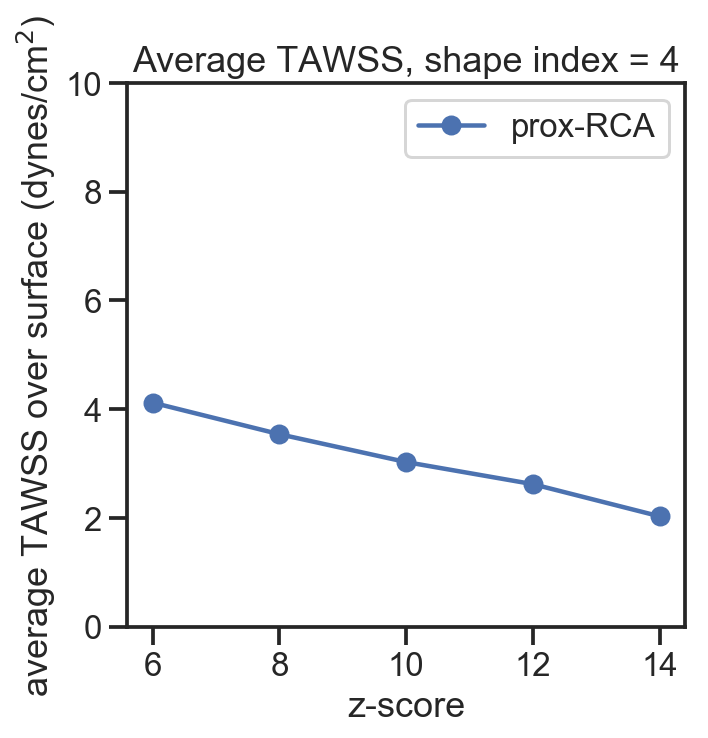

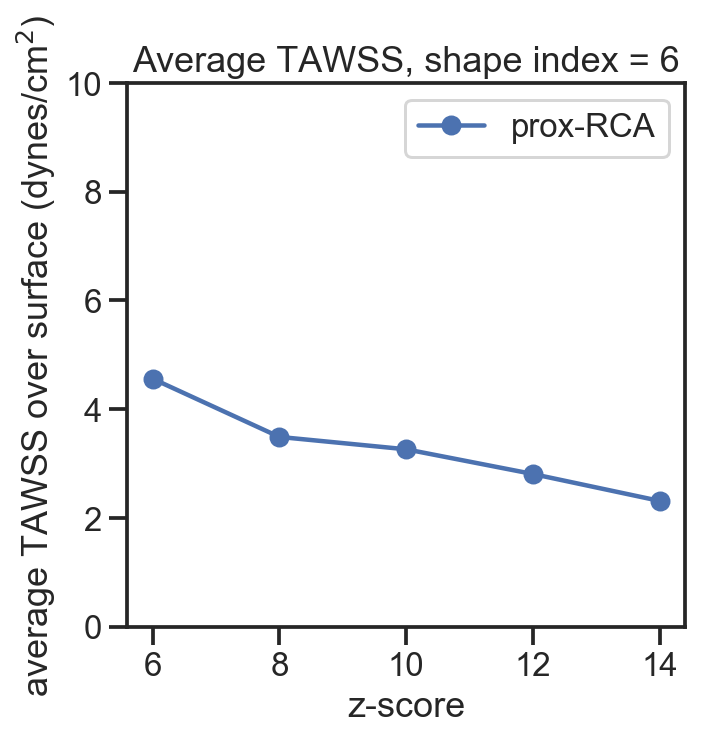

In [24]:
labels = {'prox-RCA': proximal, 
          'med-RCA': medial, 
          'dist-RCA': distal,
          #'prox-LAD': left
         }

for shape in shapes: 
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    for label, location_sizes in labels.iteritems():
        vtawss_surface_averages = np.zeros(len(location_sizes))
        for c, size in enumerate(location_sizes):
            source = vtawss_rca if 'RCA'in label else vtawss_lad
            
            try:
                vtawss_surface_averages[c] = source[shape + '_' + size]
            except:
                continue
        
        if not np.any(vtawss_surface_averages): continue
        ax.plot(z_scores, vtawss_surface_averages, label=label, marker='o')
        
    plt.legend()
    plt.xlabel('z-score')
    plt.ylabel(r'average TAWSS over surface (dynes/cm$^2$)')
    plt.title('Average TAWSS, shape index = ' + shape[-1] )
    plt.ylim(0, 10)
    ax.set_xticks(z_scores)
            

### ANIMATIONS

Here, we will produce an animation showing the relationship between shape index and fractional area under dynamic WSS cutoff, stratified by aneurysm z-score

In [127]:

# animation_vessel = 'RCA/'
animation_vessel = 'LAD/'
if animation_vessel == 'LAD/': 
    area_fracs = all_area_fractions_lad
    sizes = ['lad1', 'lad2', 'lad3', 'lad4', 'lad5']
else: 
    area_fracs = all_area_fractions_right
    sizes = proximal

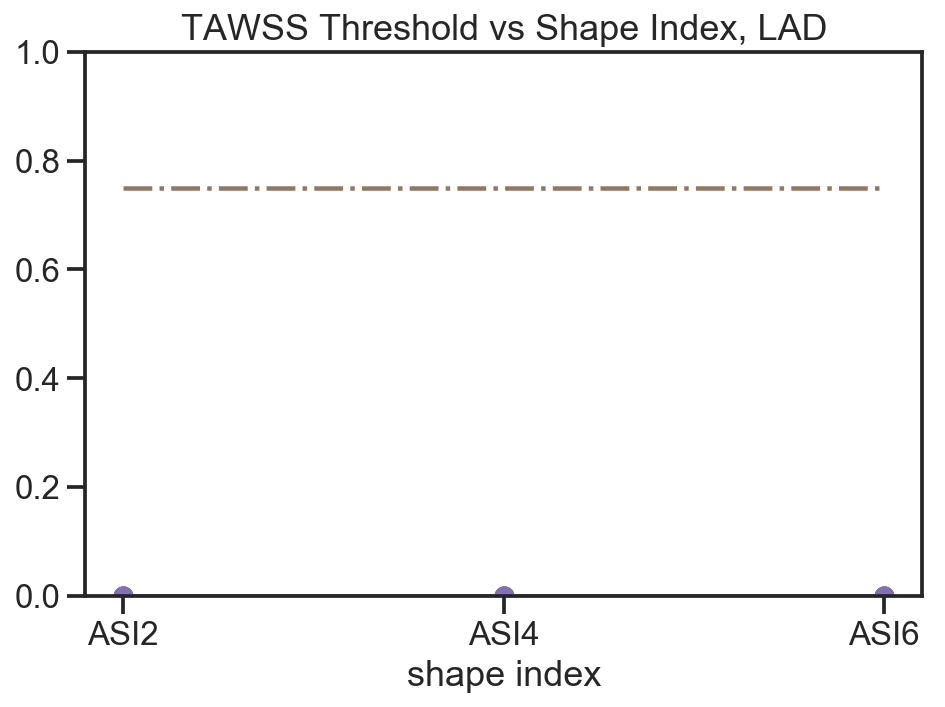

In [26]:
labels = ['prox', 'med', 'dist']
plotted_z_scores = [6, 8, 10, 12, 14]
threshold_bounds = np.arange(.05, 10.0, .5)
plot_idx = 2

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.xlabel('shape index')
plt.title('TAWSS Threshold vs Shape Index, ' + animation_vessel[:-1] )
plt.ylim(0, 1)

# initialize the lines
lines = []
for index in range(len(plotted_z_scores)):
    lobj = ax.plot(shapes,[0, 0, 0],lw=2, marker='o', label='z-score = ' + str(plotted_z_scores[index]))[0]
    lines.append(lobj)

def init(): 
    ax.plot(shapes, [.75, .75, .75], linestyle='-.')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
    return lines

def animate(plot_idx): 
    ys =[]
    for k, size in enumerate(sizes):  
        vtawss_sub_threshold_fracs = np.zeros(len(shapes))
        for c, shape in enumerate(shapes):
            vtawss_sub_threshold_fracs[c] = area_fracs[shape + '_' + size][plot_idx]
        ys.append(vtawss_sub_threshold_fracs)
        
    for lnum,line in enumerate(lines):
        line.set_ydata(ys[lnum]) # set data for each line separately. 

    ax.set_ylabel('Fraction of Surface Area Under %.2f'%(threshold_bounds[plot_idx]))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return lines
    

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(threshold_bounds), interval=600, blit=True)


In [27]:
HTML(anim.to_jshtml())

Capture specific frames for non-animation visualization

In [28]:
real_clin_threshold_fracs = [0.021552641,
                            0.197127003,
                            0,
                            0.008658212,
                            0.001524033,
                            0.01841449,
                            0,
                            0.010220732,
                            0.038200863,
                            0.492747024,
                            0.18731641,
                            0.127003774,
                            0.103511406,
                            0.315111157,
                            0.6698711,
                            0.799483338,
                            0.688295223]

real_clin_asis = [0.925595431,
                0.865269613,
                0.81143857,
                1.695360514,
                1.888652381,
                1.035256881,
                0.504989282,
                2.906349745,
                1.577721572,
                2.157217122,
                1.905305506,
                3.386546434,
                1.880745211,
                1.645944859,
                1.800550603,
                1.649212011,
                1.994407569]

right_volumes = {
    'ASI2': {'prox':[0.37912, 0.48379, 0.68129, 0.88389, 1.1165],
             'med': [0.2626, 0.40586, 0.58183, 0.80693, 1.0183], 
             'dist': [.19253, 0.30718, .45923, .65179, .89421]}, 
    'ASI4': {'prox':[0.90235, 1.3218, 1.9063, 2.5823, 2.8892]},
    'ASI6': {'prox':[1.4014, 1.4651, 2.109, 2.9514, 4.0107]},
}


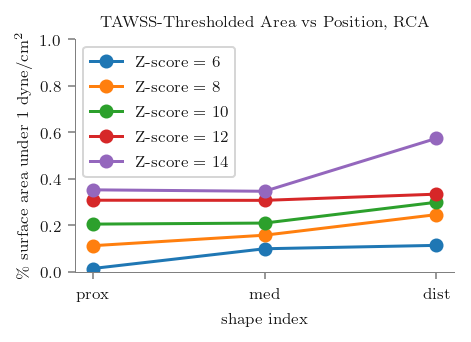

In [76]:
labels = ['prox', 'med', 'dist']
plotted_z_scores = ['6', '8', '10', '12', '14']
vessel = "RCA/"
cur_asi = 'ASI2'

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
format_axes(ax)

vals = np.zeros((len(labels), len(plotted_z_scores)))

for i, pos in enumerate([proximal, medial, distal]): 
    for j, (size, z) in enumerate(zip(pos, plotted_z_scores)): 
        vals[i,j] = all_area_fractions_right[cur_asi + '_' + size][2]


for i, z in enumerate(plotted_z_scores): 
    ax.plot(labels, vals[:,i], label='Z-score = ' + str(z), marker='o')


# plt.legend(loc='right', bbox_to_anchor=(1.32,1))
plt.legend()
plt.xlabel('shape index')
plt.ylabel(r'$\%$ surface area under 1 dyne/cm$^2$')
plt.title('TAWSS-Thresholded Area vs Position, ' + vessel[:-1] )
ax.set_ylim(0, 1)
plt.show()

(0, 1)

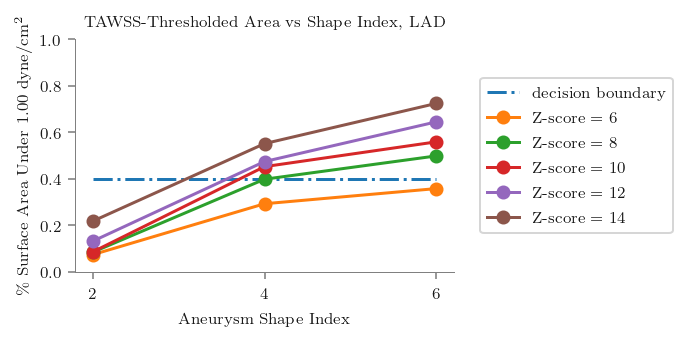

In [128]:
labels = ['prox', 'med', 'dist']
plotted_z_scores = [6, 8, 10, 12, 14]
threshold_bounds = np.arange(.05, 10.0, .5)
plot_idx = 2

fig = plt.figure() #plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
format_axes(ax)

ax.plot([2, 4, 6], [.4, .4, .4], linestyle='-.', label='decision boundary')

for k, size in enumerate(sizes):  
    vtawss_sub_threshold_fracs = np.zeros(len(shapes))
    for c, shape in enumerate(shapes):
        vtawss_sub_threshold_fracs[c] = area_fracs[shape + '_' + size][plot_idx]
    
    ax.plot([2, 4, 6], vtawss_sub_threshold_fracs, label='Z-score = ' + str(plotted_z_scores[k]), marker='o')
    
# ax.scatter(real_clin_asis, real_clin_threshold_fracs, marker='x')


plt.legend(loc="right", bbox_to_anchor=(1.6, .5))
plt.xlabel('Aneurysm Shape Index')#, fontname='Arial')
plt.xticks([2, 4, 6])
plt.ylabel(r'\% Surface Area Under 1.00 dyne/cm$^2$')#, fontname='Arial')
# plt.ylabel('Fraction of Surface Area Under %.2f'%(threshold_bounds[plot_idx]))
plt.title('TAWSS-Thresholded Area vs Shape Index, ' + animation_vessel[:-1])#, fontname='Arial')
plt.savefig("../figures/thresh_area_lad_shape.eps", bbox_inches = "tight")
plt.ylim(0, 1)
# plt.show()


In [31]:
print all_area_fractions_right

{'ASI2_m4': array([3.72162525e-04, 1.14124288e-01, 3.06686455e-01, 4.06008104e-01,
       4.87070721e-01, 5.51253026e-01, 5.90609589e-01, 6.22333537e-01,
       6.47313816e-01, 6.71925232e-01, 6.88699539e-01, 7.01141705e-01,
       7.15657352e-01, 7.29772870e-01, 7.41783178e-01, 7.51545708e-01,
       7.59493055e-01, 7.68537314e-01, 7.78094394e-01, 7.85667314e-01]), 'ASI2_m5': array([0.00084155, 0.14348627, 0.34576971, 0.4433132 , 0.54157243,
       0.59535192, 0.63120123, 0.65717592, 0.68363758, 0.70408644,
       0.72015319, 0.73722505, 0.7526097 , 0.76507441, 0.77591412,
       0.78591889, 0.79407512, 0.80417773, 0.81243708, 0.82218168]), 'ASI2_m1': array([0.        , 0.02268436, 0.09832771, 0.2473909 , 0.35214442,
       0.40197653, 0.44269403, 0.47546733, 0.50521035, 0.52674416,
       0.54332047, 0.56329128, 0.5781512 , 0.59586567, 0.61053036,
       0.627053  , 0.63948995, 0.65351283, 0.66773385, 0.67904487]), 'ASI2_m2': array([0.        , 0.04616233, 0.15663001, 0.31738979, 0.4

In [32]:
print right_volumes


{'ASI6': {'prox': [1.4014, 1.4651, 2.109, 2.9514, 4.0107]}, 'ASI4': {'prox': [0.90235, 1.3218, 1.9063, 2.5823, 2.8892]}, 'ASI2': {'med': [0.2626, 0.40586, 0.58183, 0.80693, 1.0183], 'dist': [0.19253, 0.30718, 0.45923, 0.65179, 0.89421], 'prox': [0.37912, 0.48379, 0.68129, 0.88389, 1.1165]}}


Text(0.5,1,'TAWSS-Thresholded Area vs Aneurysm Volume')

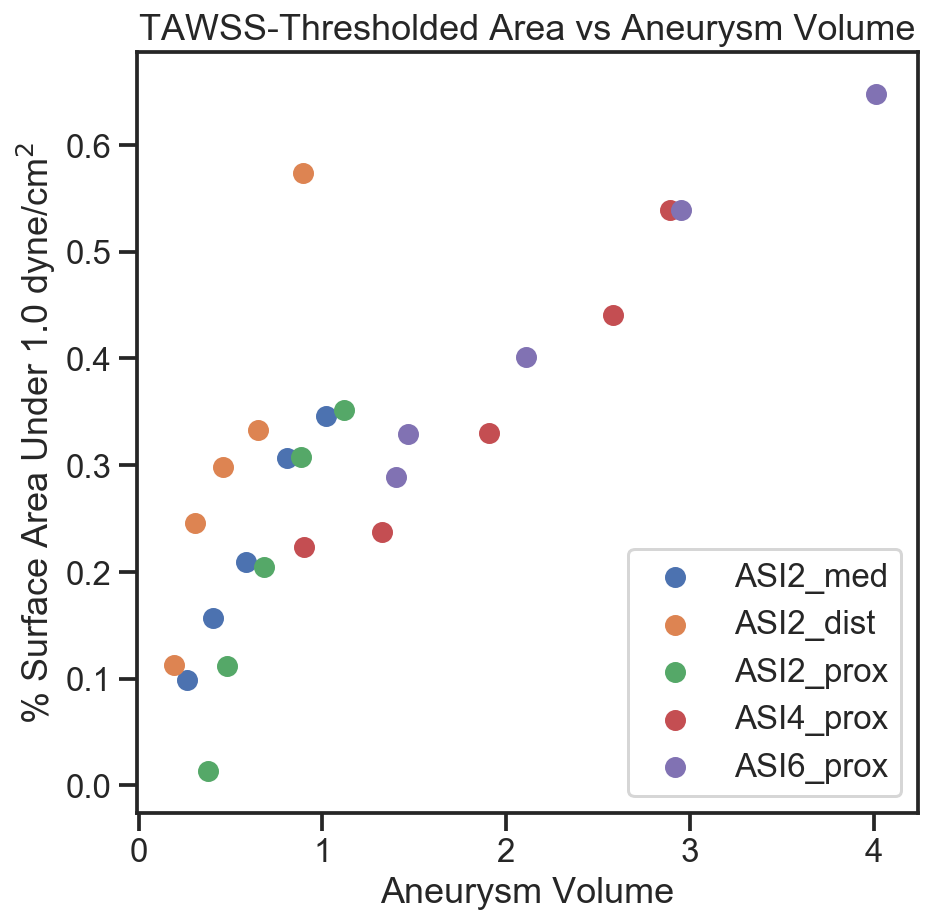

In [33]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

for shape in shapes: 
    pos_sizes = {'prox': proximal, 
                 'med': medial, 
                 'dist': distal}
    
    if shape == 'ASI6' or shape == 'ASI4': 
        pos_sizes = {'prox': proximal}
        
    
    for position, size_list in pos_sizes.iteritems():
        accumulated = []
        for size in size_list: 
            accumulated.append(all_area_fractions_right[shape + '_' + size][2])
        ax.scatter(right_volumes[shape][position], accumulated, label='_'.join([shape, position]))

plt.legend()
plt.ylabel(r'% Surface Area Under 1.0 dyne/cm$^2$')
plt.xlabel('Aneurysm Volume')
plt.title('TAWSS-Thresholded Area vs Aneurysm Volume')